# 0.0 IMPORTS

In [1]:
import math
import pickle
import datetime
import inflection

import pandas            as pd
import numpy             as np
import seaborn           as sns
import xgboost           as xgb
import matplotlib.pyplot as plt


from IPython.core.display   import HTML
from scipy                  import stats
from IPython.display        import Image
from matplotlib.gridspec    import GridSpec
#from boruta                import BorutaPy
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error, mean_absolute_error



## 0.1. Helper Functions

In [71]:
# Create a function with my configurations:
def my_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [42, 25]
    plt.rcParams['font.size'] = 8
        
    # notebook settings
    display(HTML('<style>.container{width:80% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
        
    # seaborn settings
    sns.set(rc={'figure.figsize':(42,21)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.3)
    


# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 

# Create Cramer's V:

def cramer_v(x , y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r ,k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max(0 , chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr -1 ,    rcorr -1 ) ) )

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#     
## Create the performance functions:
# defining the performance function: mean_absolute_percentage_error → Now Available in sklearn

def mean_absolute_percentage_error(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean(np.abs((y - yhat)/ y ))


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    # Cria um Dataframe para adionar os valores de todos os erros:
    return pd.DataFrame( {'Model Name' : model_name,
                          'MAE': mae,
                          'MAPE' : mape,
                          'RMSE' : rmse }, index = [0])



# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#     
## Create Cross-Validation function:

def cross_validation( x_training, k_fold, model_name, model, verbose = False ):
    # create function to split dataset acording KFold Numbers:
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, k_fold + 1 ) ):

        # KFold iteration:
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end date for validation:
        validation_start_date = x_training['date'].max() - datetime.timedelta( days= k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7 )

        # filtering dataset, create a training dataset:
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date)]

        # training and validation dataset:
        xtraining = training.drop( [ 'date', 'sales' ], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop( ['sales', 'date' ], axis= 1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )    

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ) ) #
        print(m_result)
               
        # store performance for each kfold iteration:
        mae_list.append( m_result['MAE'] )
        mape_list.append(m_result['MAPE'] )
        rmse_list.append(m_result['RMSE'] )

    return pd.DataFrame ({'Model Name' : model_name,
     'MAE CV' : np.round(np.mean( mae_list ) , 2 ).astype(str)  + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype(str),
     'MAPE CV': np.round(np.mean( mape_list ) , 2 ).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype(str),
     'RMSE CV': np.round(np.mean( rmse_list ) , 2 ).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype(str)
    } ,  index = [0])

## 0.2. Loading Data

In [4]:
# load datasets
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# Merging datsets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. STEP 01: DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename:
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NAs

In [10]:
# Check the sum of NA by column:
df1.isna().sum() 

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NAs

In [11]:
# Fill competition_distance:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# fill competition_open_since_month:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                                          else x['competition_open_since_month'] , axis=1)

# fill competition_open_since_year:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                                        else x['competition_open_since_year'] , axis=1)

# fill NA in promo2_since_week:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                              else x['promo2_since_week'] , axis=1)

# fill NA in promo2_since_year:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                              else x['promo2_since_year'] , axis=1)

# fill promo_interval:
month_map = {1 : 'Jan', 2 : 'Fev', 3  : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8  : 'Aug', 9  : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

# preencher os valores NA com 0:
df1['promo_interval'].fillna(0, inplace = True)

# fazer um mapeamento e busca do mês usando um dicionário, conforme número do mês em 'date': 
df1['month_map'] = df1['date'].dt.month.map( month_map )

#
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6. Change Types    

In [12]:
# 'competition_open_since_month' and 'competition_open_since_year' are integer, not float:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# 'promo2_since_week' and 'promo2_since_year' are integer, not float:
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [13]:
# Separando as Variáveis em Numéricas e Categóricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [14]:
# Central Tendency: Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame( num_attributes.apply(np.max) - num_attributes.apply(np.min) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [15]:
# check for unique values by columns:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

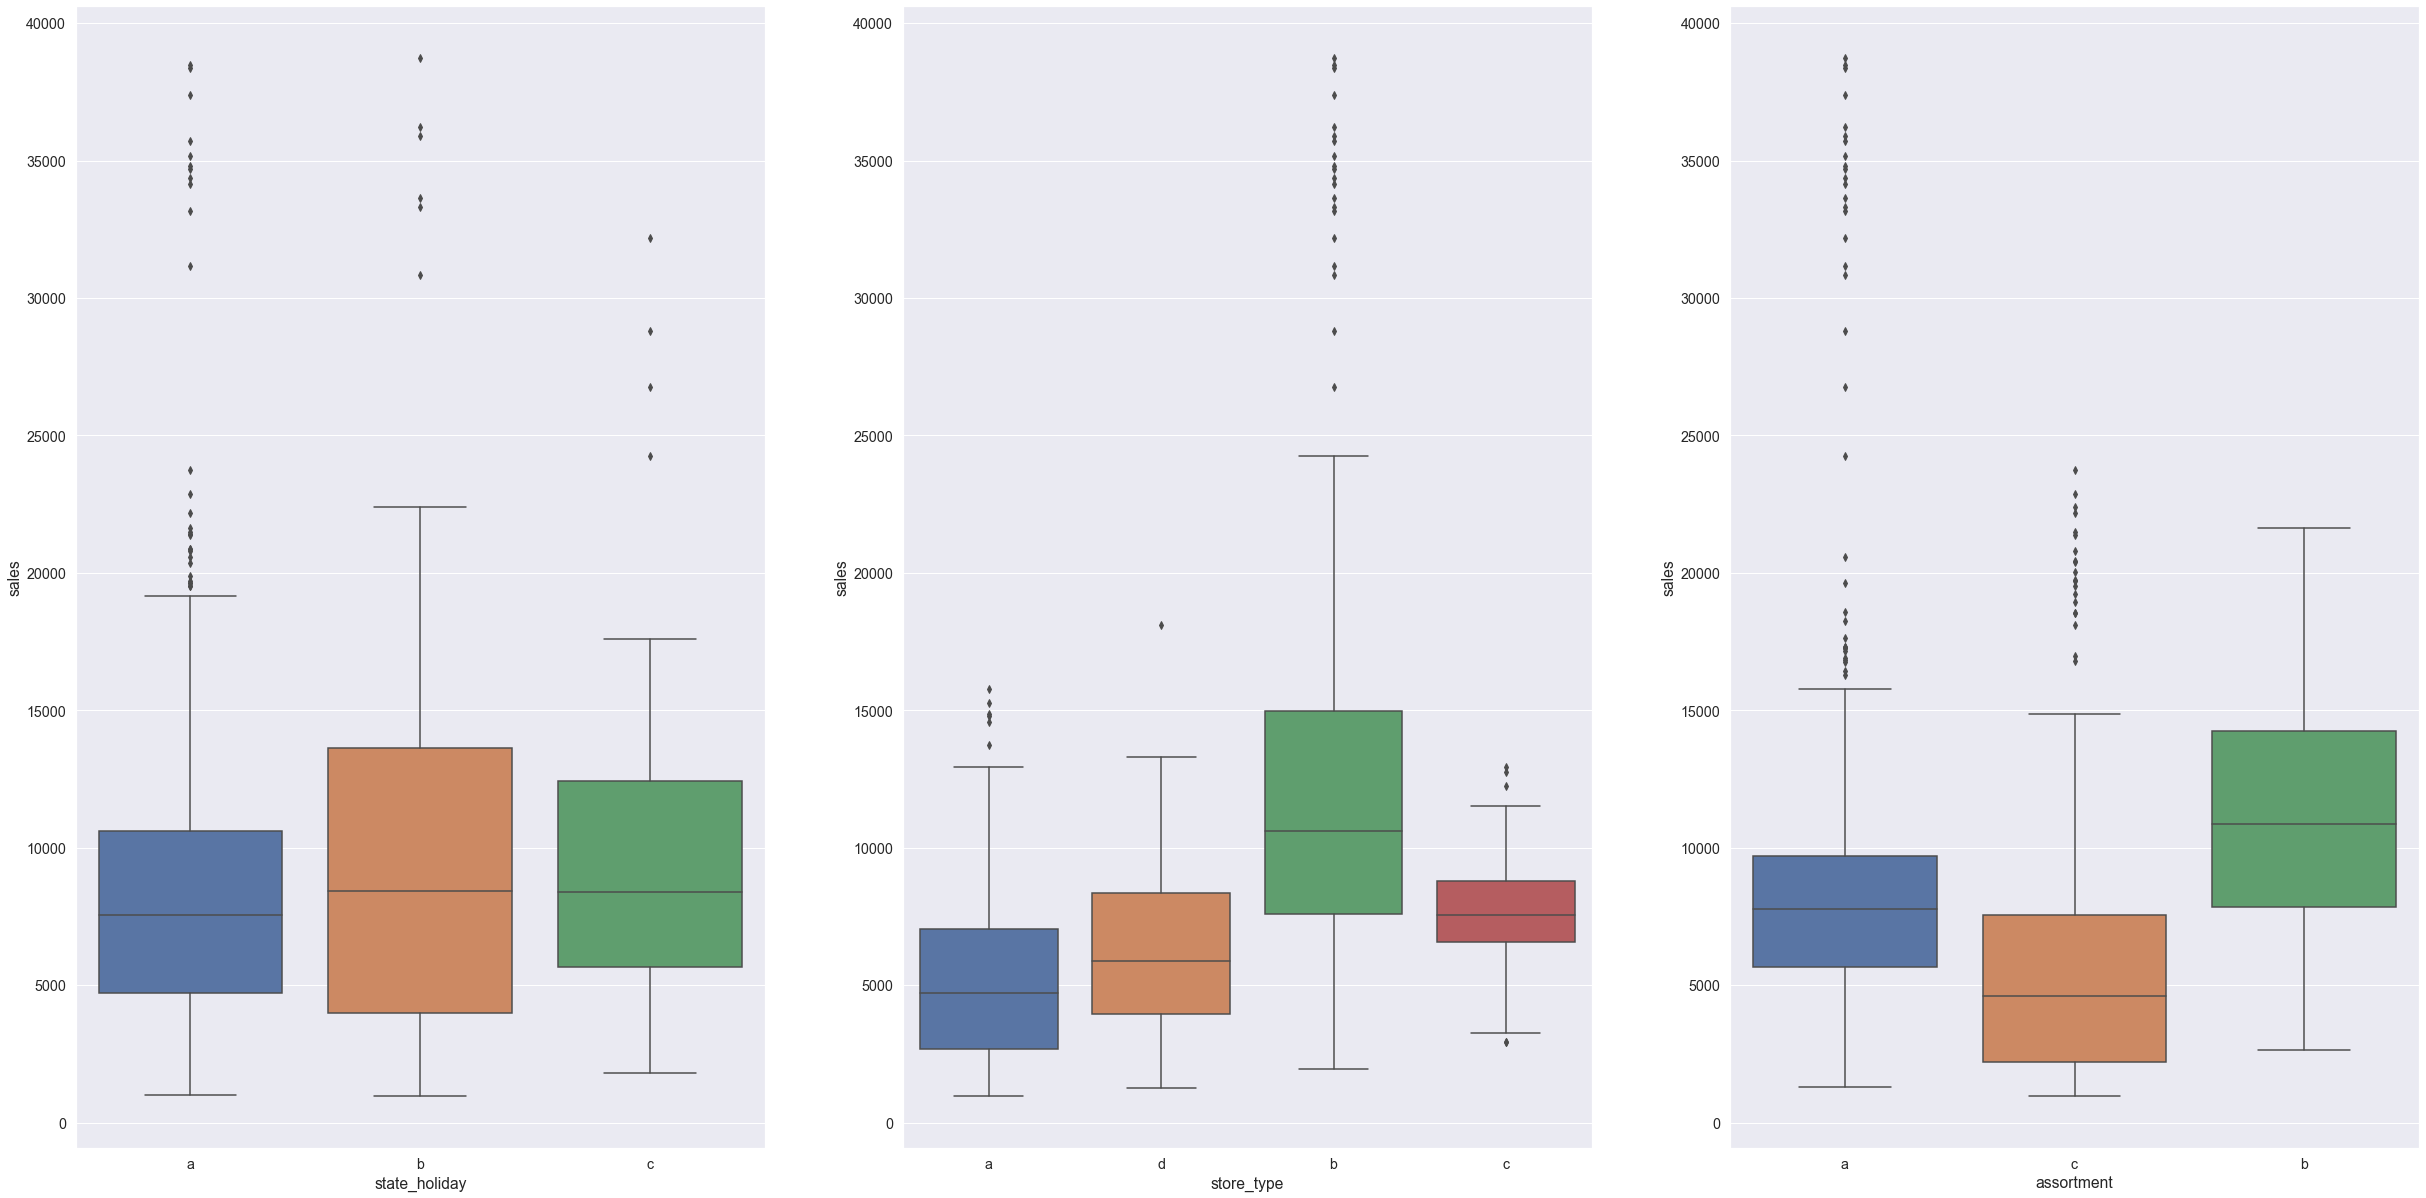

In [16]:
# load configurations:
my_settings()

# filter: sales during a state holiday (aux1)
aux1 = df1[ ( df1['state_holiday'] != '0' ) & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday' , y= 'sales' , data= aux1);

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type' , y= 'sales' , data= aux1);

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment' , y= 'sales' , data= aux1);

# 2.0. STEP 02: FEATURE ENGINEERING

In [17]:
df2=df1.copy()

## 2.1. Mind Map Hypothesis

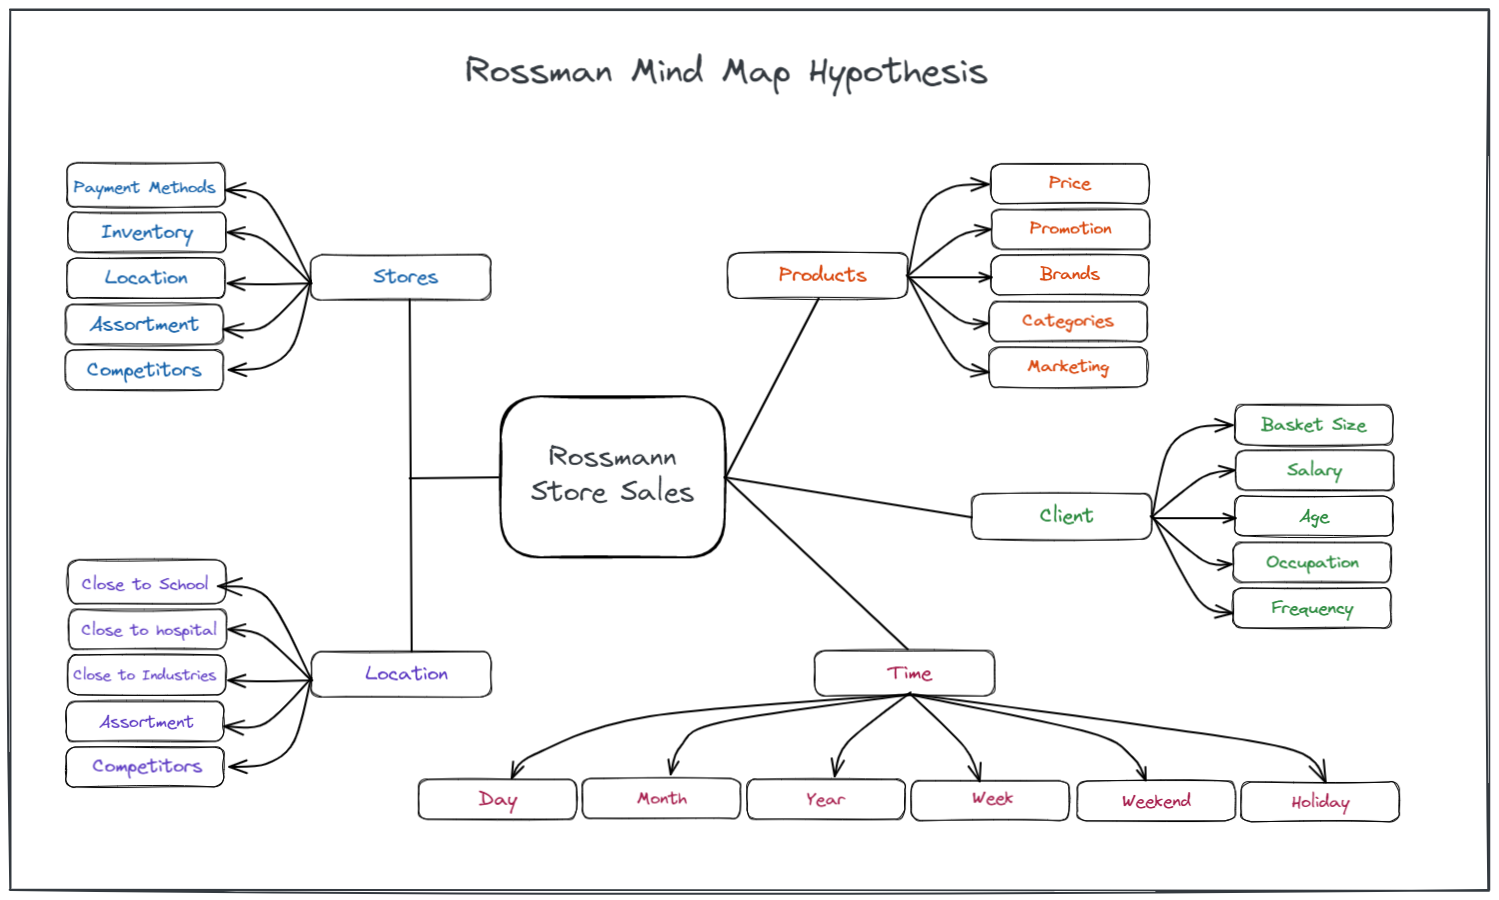

In [2]:
Image(data = 'Rossmann-mind-map-hypothesis.png')

## 2.2. Creating Hypothesis

### 2.2.1. Store Hypothesis

**1.** Stores with larger staff should sell more.

**2.** Stores with more inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less. 

### 2.2.2. Product Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that display more product in shop windows should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores that have lower prices for longer on products should sell more.

**5.** Stores with more aggressive promotions (larger discounts) should sell more.

**6.** Stores with promotions active for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Final Hypothesis List

**Store Hypothesis:**
    
**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.

------------------------------------------------- ------------------------------------------------- ------------------------
**Product Hypothesis:**

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

------------------------------------------------- ------------------------------------------------- ------------------------
**Time Assumption:**

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [18]:
# Creating column year:
df2['year'] = df2['date'].dt.year

# Creating column month:
df2['month'] = df2['date'].dt.month

# Creating column day:
df2['day'] = df2['date'].dt.day

# Creating column week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype( 'int64')

# Creating column year_week:
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# Creating competition_since (As we don't have the day, let's consider the 1st of each month.):
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month= x['competition_open_since_month'] , day= 1), axis= 1)

# Creating column competition_time_month → Time in months the competitor is open:
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply(lambda x: x.days ).astype('int64') # para manter granularidade mensal

# Creating column promo since: 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7) )

# Creating column promo_time_week (time the promo is active in weeks):
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype('int64')

# Converting assortment:
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b'  else 'extended')

# Converting state holiday:
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                          else 'easter_holiday'if x == 'b' 
                                                          else 'christmas' if x == 'c' 
                                                          else 'regular_day')

In [19]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03: VARIABLES FILTERING

In [20]:
df3=df2.copy()

## 3.1. Rows Filtering

In [21]:
# open = 0  → Closed Store ; sales = 0  → No Sales, Closed Store
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Columns Selection

In [22]:
# Delete columns:
cols_drop = ['customers', 'open', 'promo_interval' , 'month_map']
df3.drop(cols_drop , axis=1 , inplace= True)

# 4.0. STEP 04: EXPLORATORY DATA ANALYSIS (EDA)

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

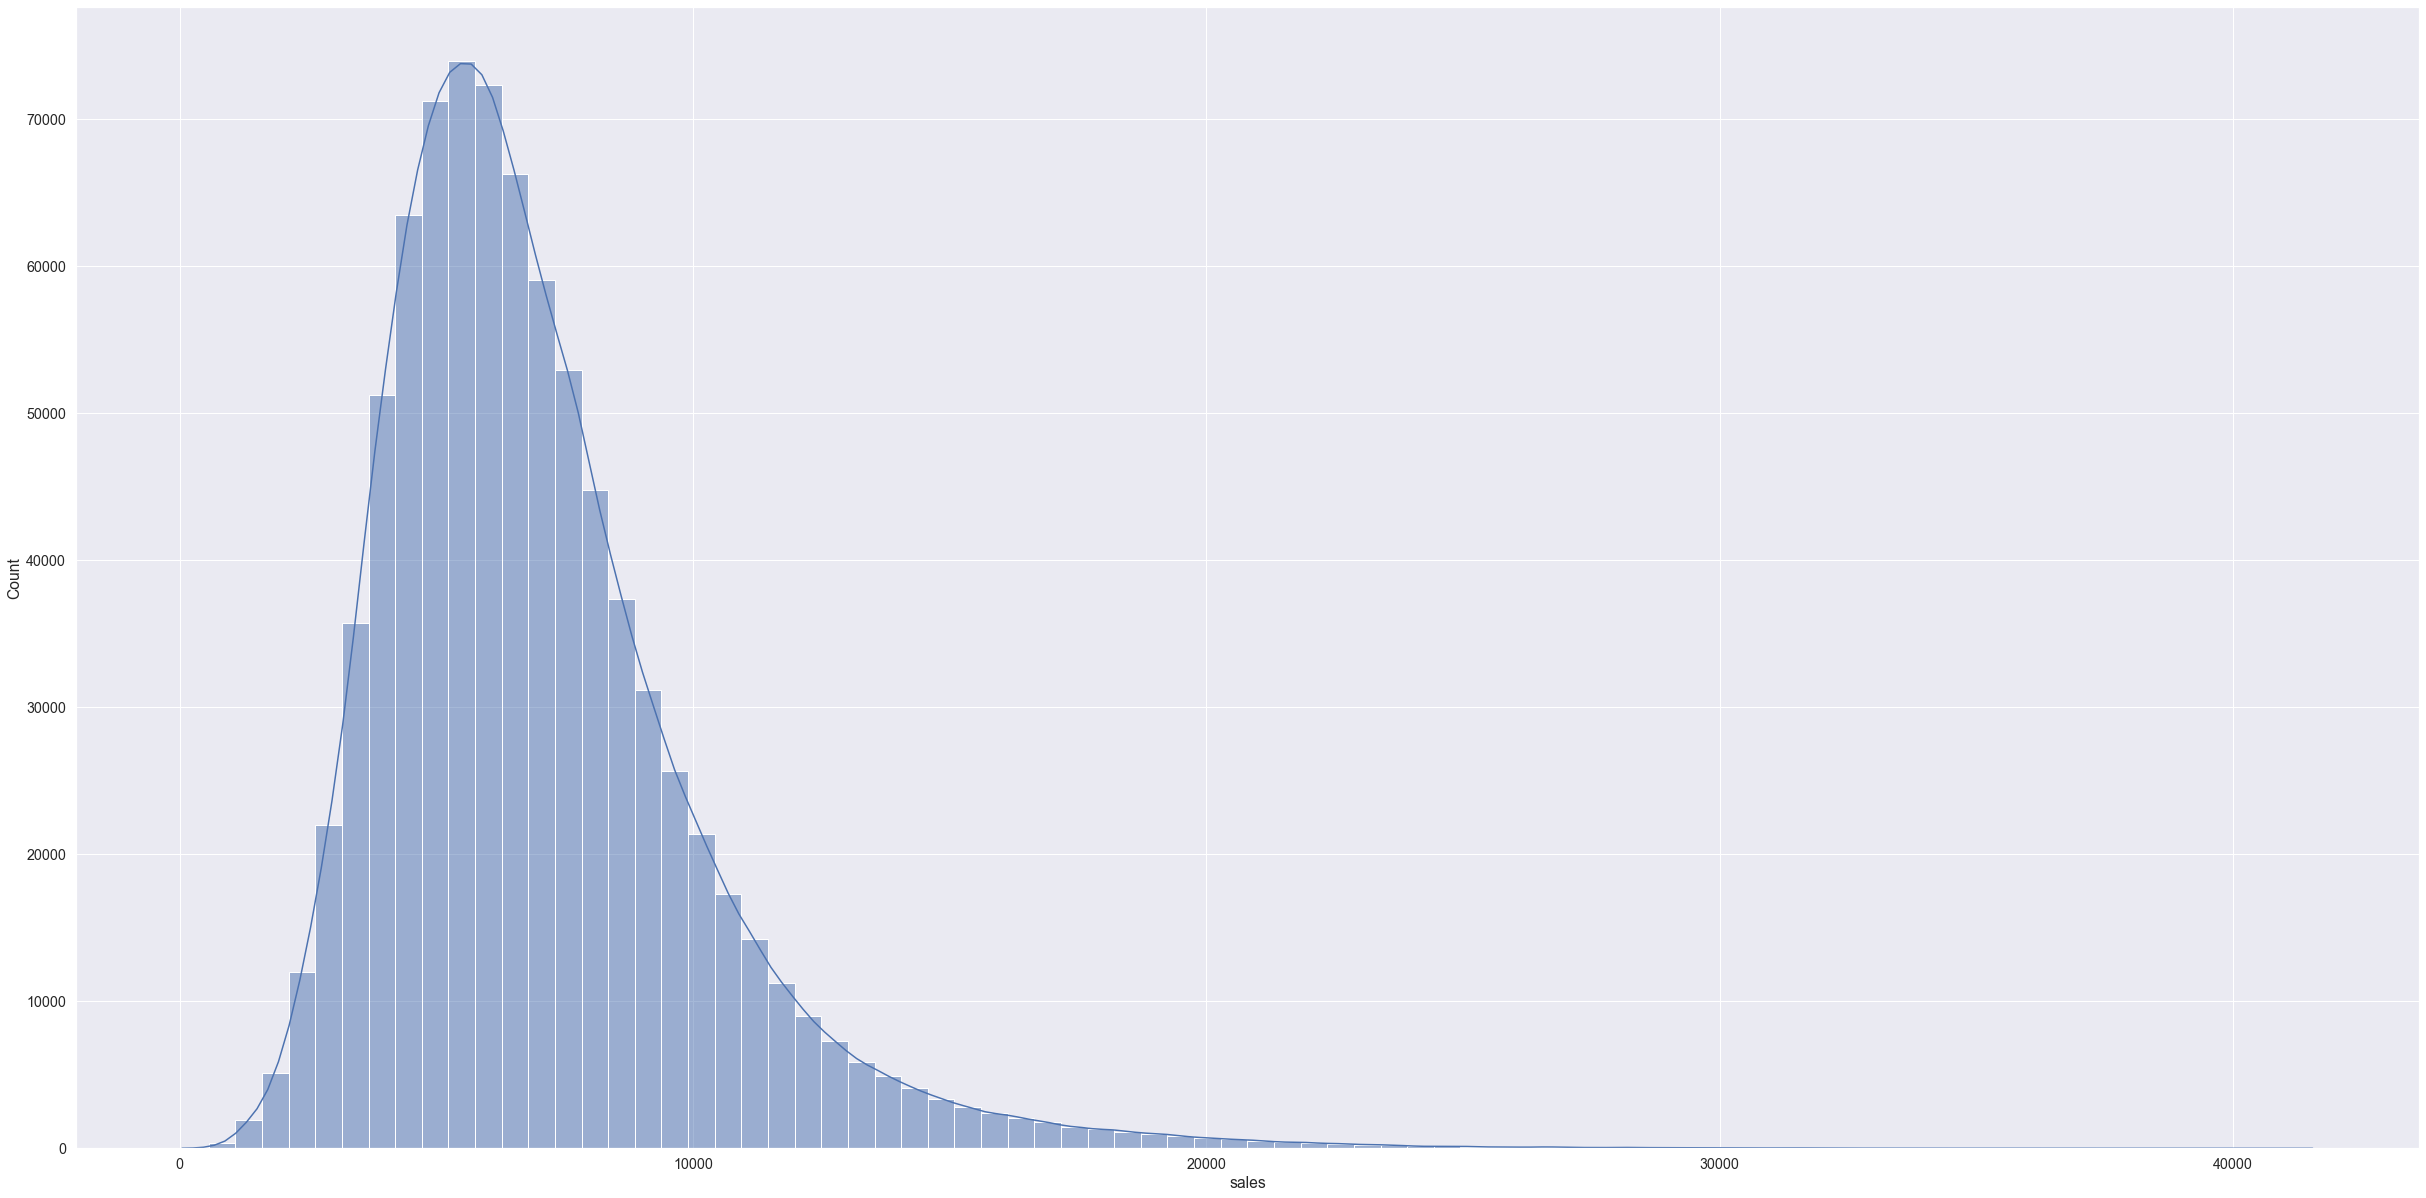

In [24]:
# Sales histogram:
sns.histplot(df4['sales'], kde= True, bins= 80);

### 4.1.2. Numerical Variables

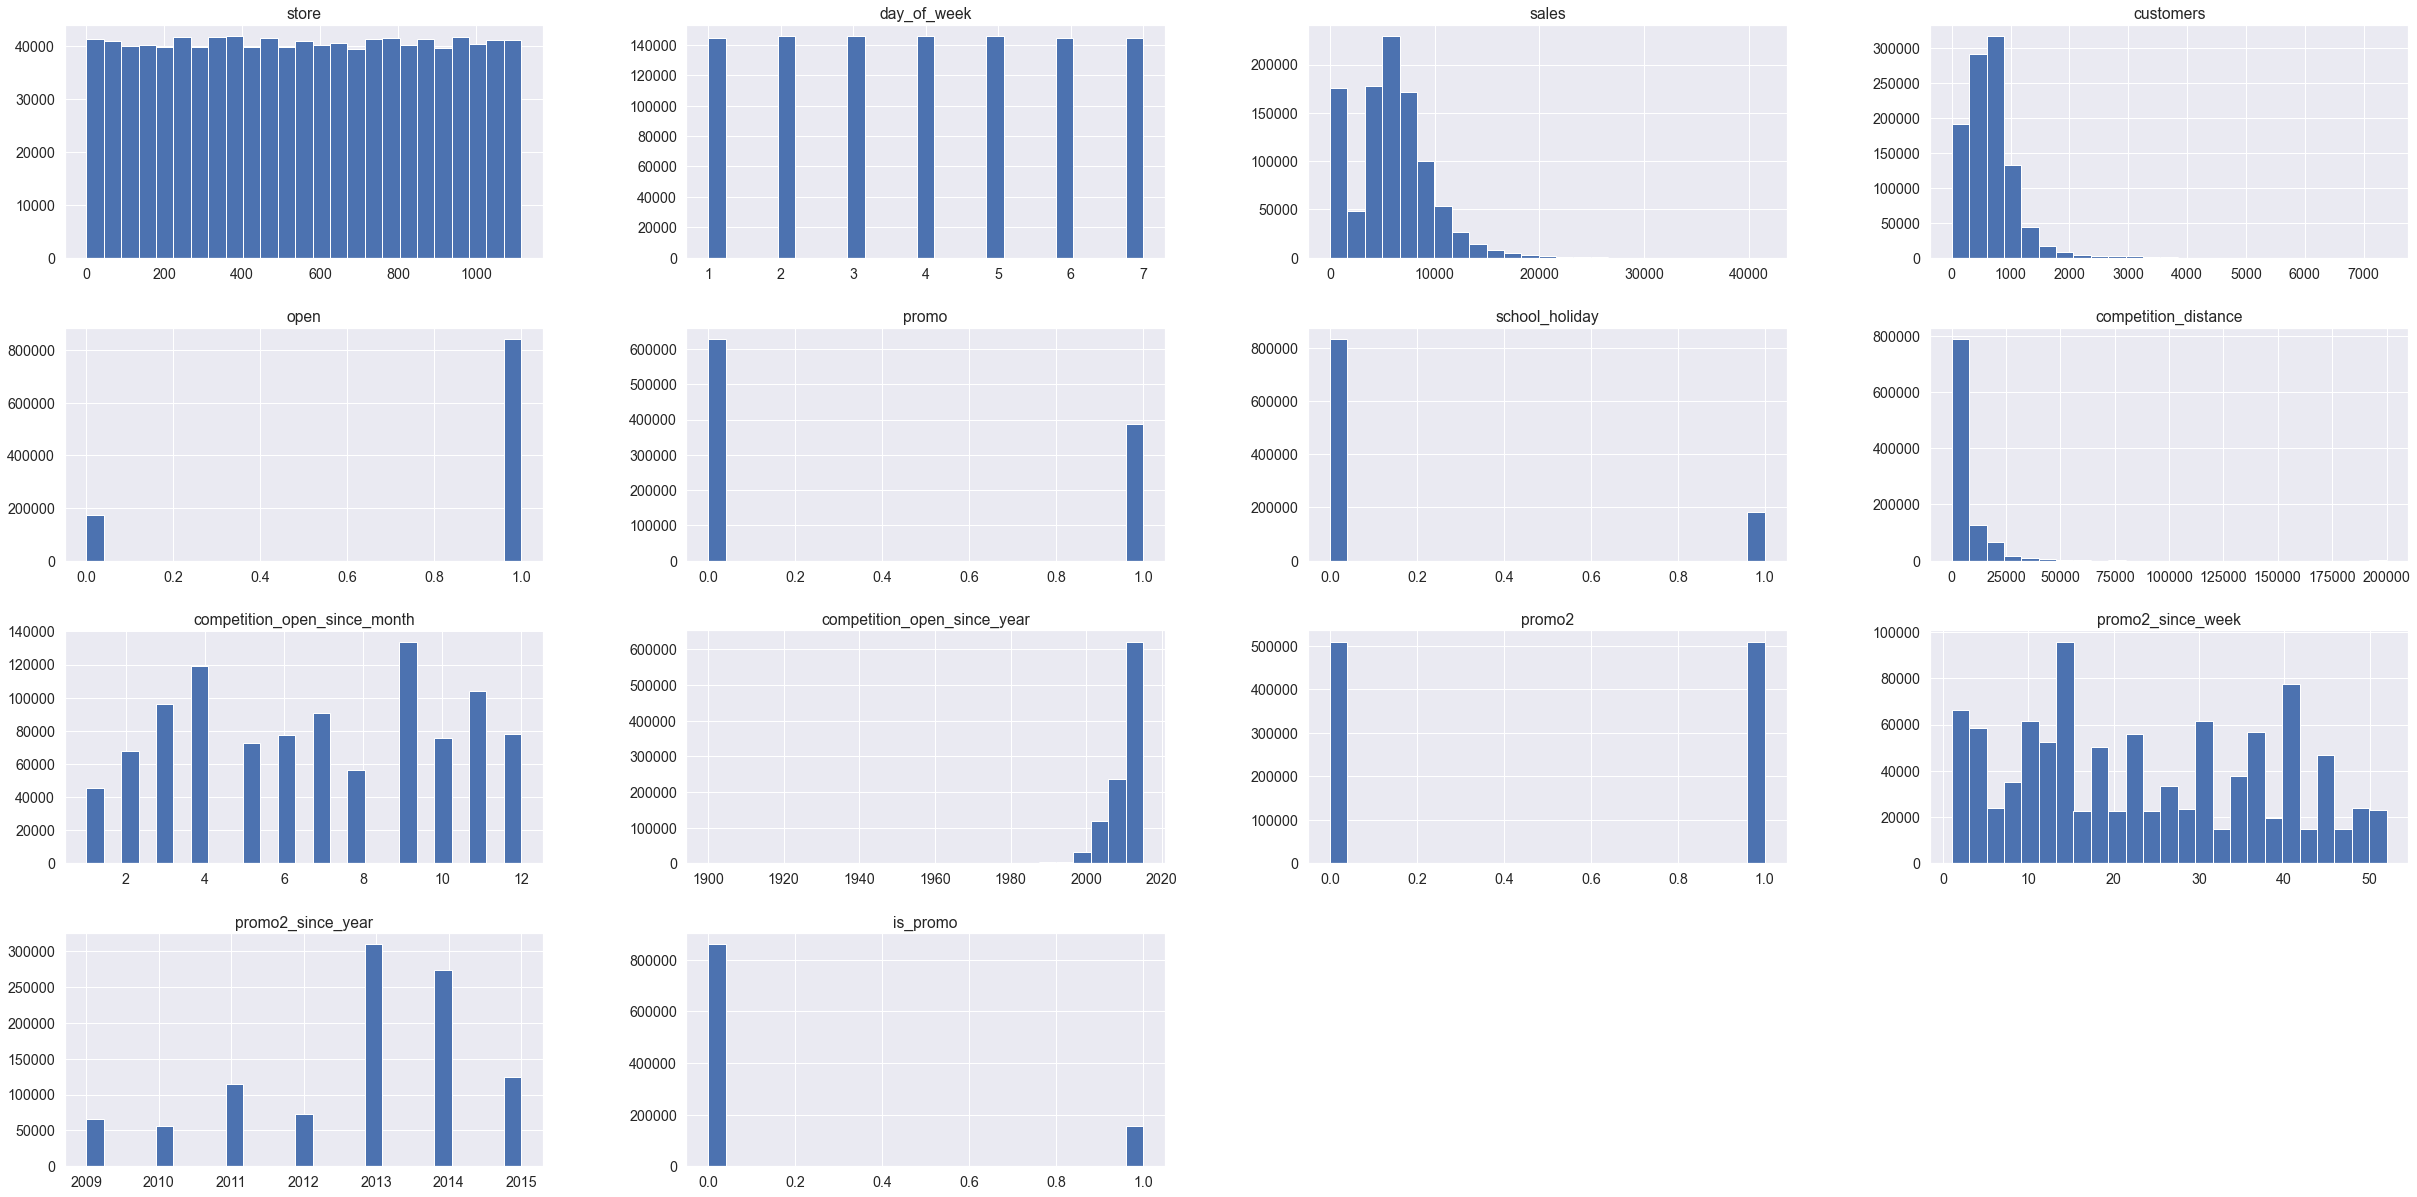

In [25]:
# Histogram of numerical variables:
num_attributes.hist( bins = 25);

### 4.1.3. Categorical Variable

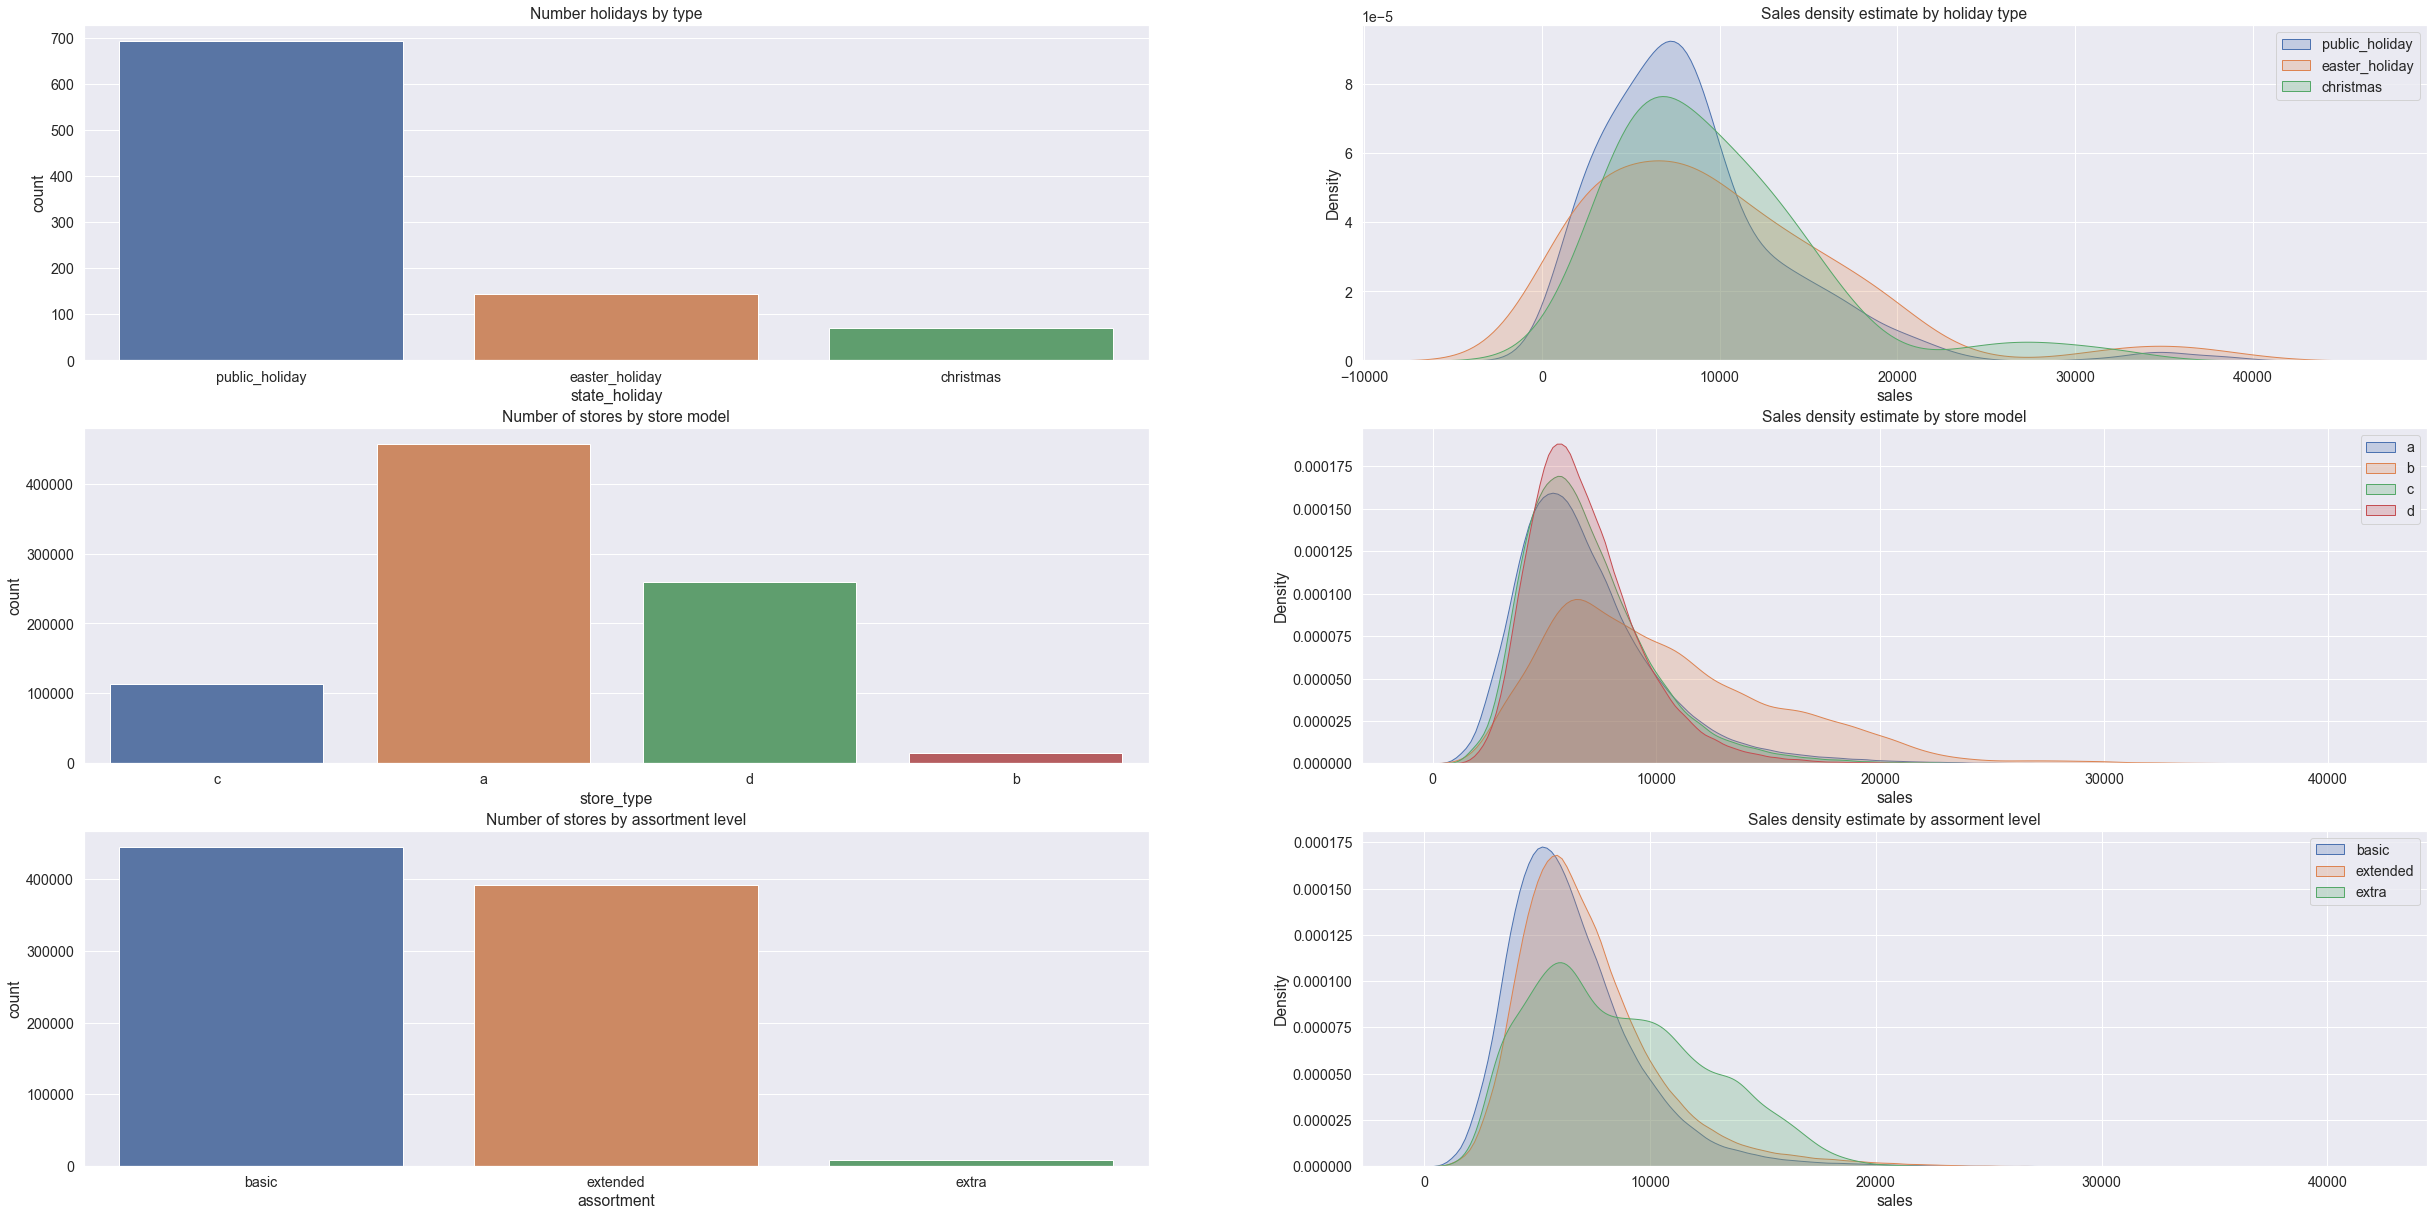

In [26]:
my_settings()
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day'] # get only holidays
sns.countplot(x = a['state_holiday']).set_title('Number holidays by type');

# kde of sales by holiday:
plt.subplot(3, 2, 2)
sns.kdeplot(data = df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label = 'public_holiday');
sns.kdeplot(data = df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade= True, label = 'easter_holiday');
sns.kdeplot(data = df4[df4['state_holiday'] == 'christmas']['sales'], shade= True, label ='christmas').set_title('Sales density estimate by holiday type');
plt.legend();

# --------------------------------------------------------------------------------------#
# store_type:
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type']).set_title('Number of stores by store model');

# kde of sales by store type:
plt.subplot(3, 2, 4)
sns.kdeplot(data = df4[df4['store_type'] == 'a']['sales'], shade=True, label = 'a');
sns.kdeplot(data = df4[df4['store_type'] == 'b']['sales'], shade= True, label = 'b');
sns.kdeplot(data = df4[df4['store_type'] == 'c']['sales'], shade= True, label ='c');
sns.kdeplot(data = df4[df4['store_type'] == 'd']['sales'], shade= True, label = 'd').set_title('Sales density estimate by store model');
plt.legend();

# --------------------------------------------------------------------------------------#
# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment']).set_title('Number of stores by assortment level');

# kde of sales by assortment type:
plt.subplot(3, 2, 6)
sns.kdeplot(data = df4[df4['assortment'] == 'basic']['sales'], shade=True, label = 'basic');
sns.kdeplot(data = df4[df4['assortment'] == 'extended']['sales'], shade= True, label = 'extended');
sns.kdeplot(data = df4[df4['assortment'] == 'extra']['sales'], shade= True, label ='extra').set_title('Sales density estimate by assorment level');
plt.legend();

## 4.2. Bivariate Analysis

### H1. Stores with a larger assortment should sell more.

**True.** Stores with a larger assortments sell more.

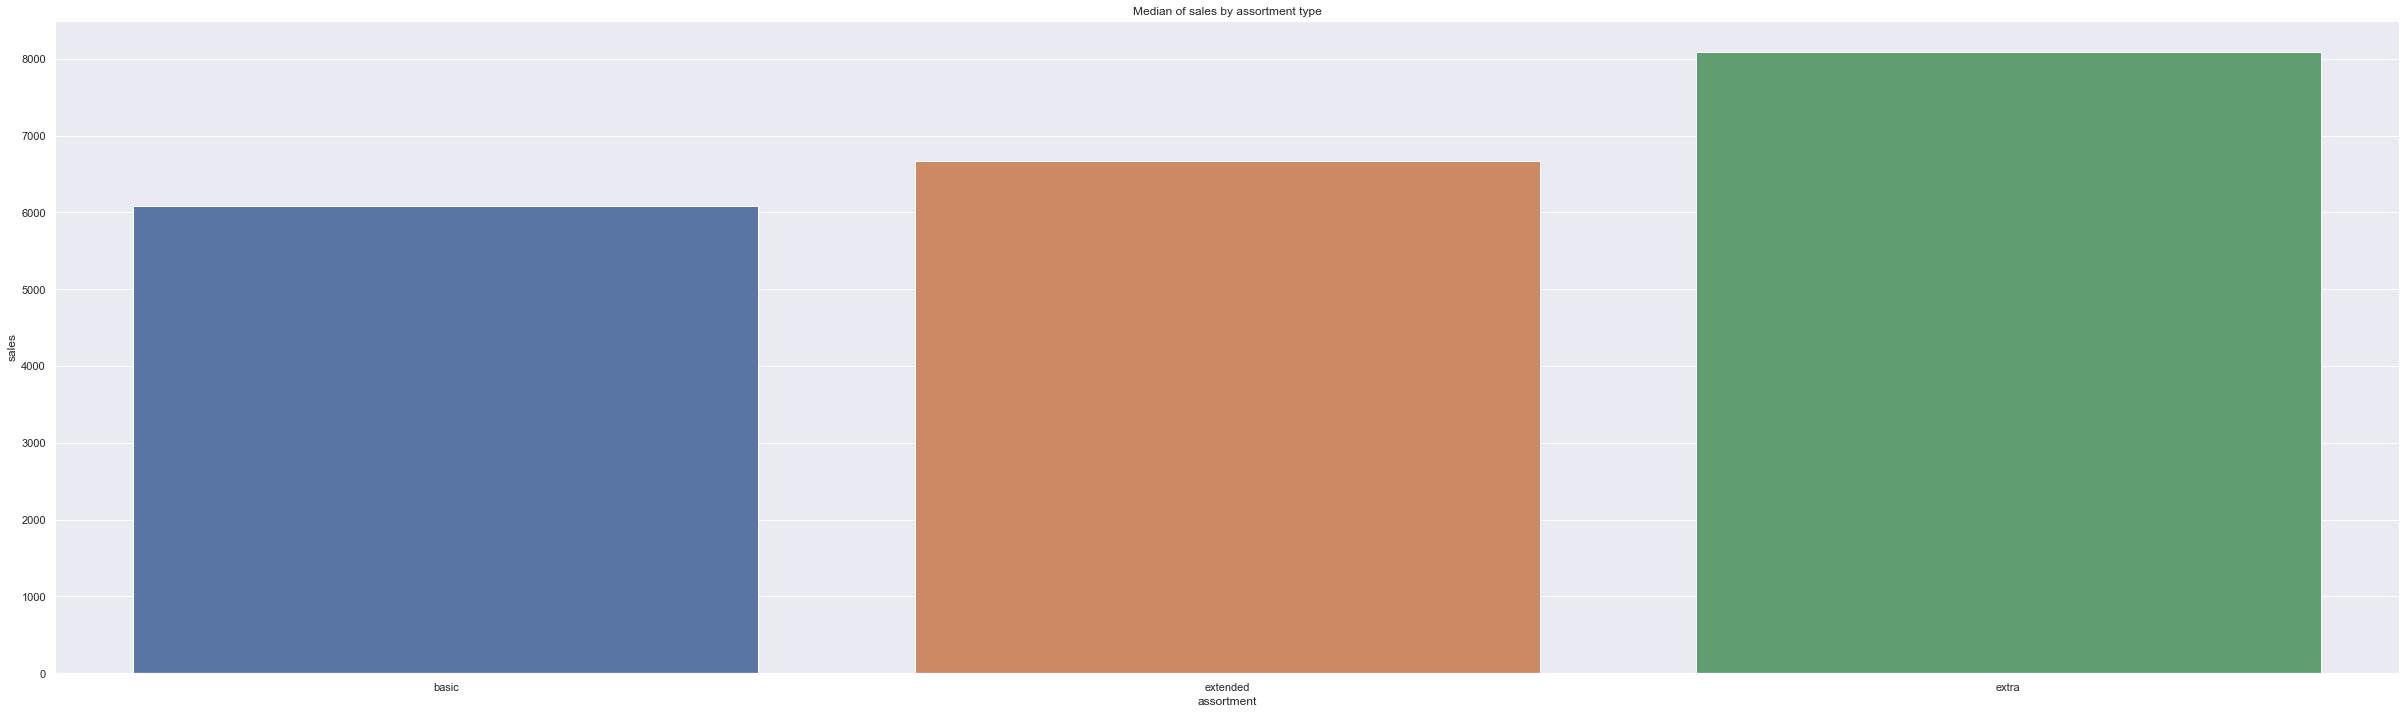

In [27]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.set(rc={'figure.figsize':(42,12)})
sns.barplot(x= 'assortment', y='sales', data=aux1).set_title('Median of sales by assortment type');

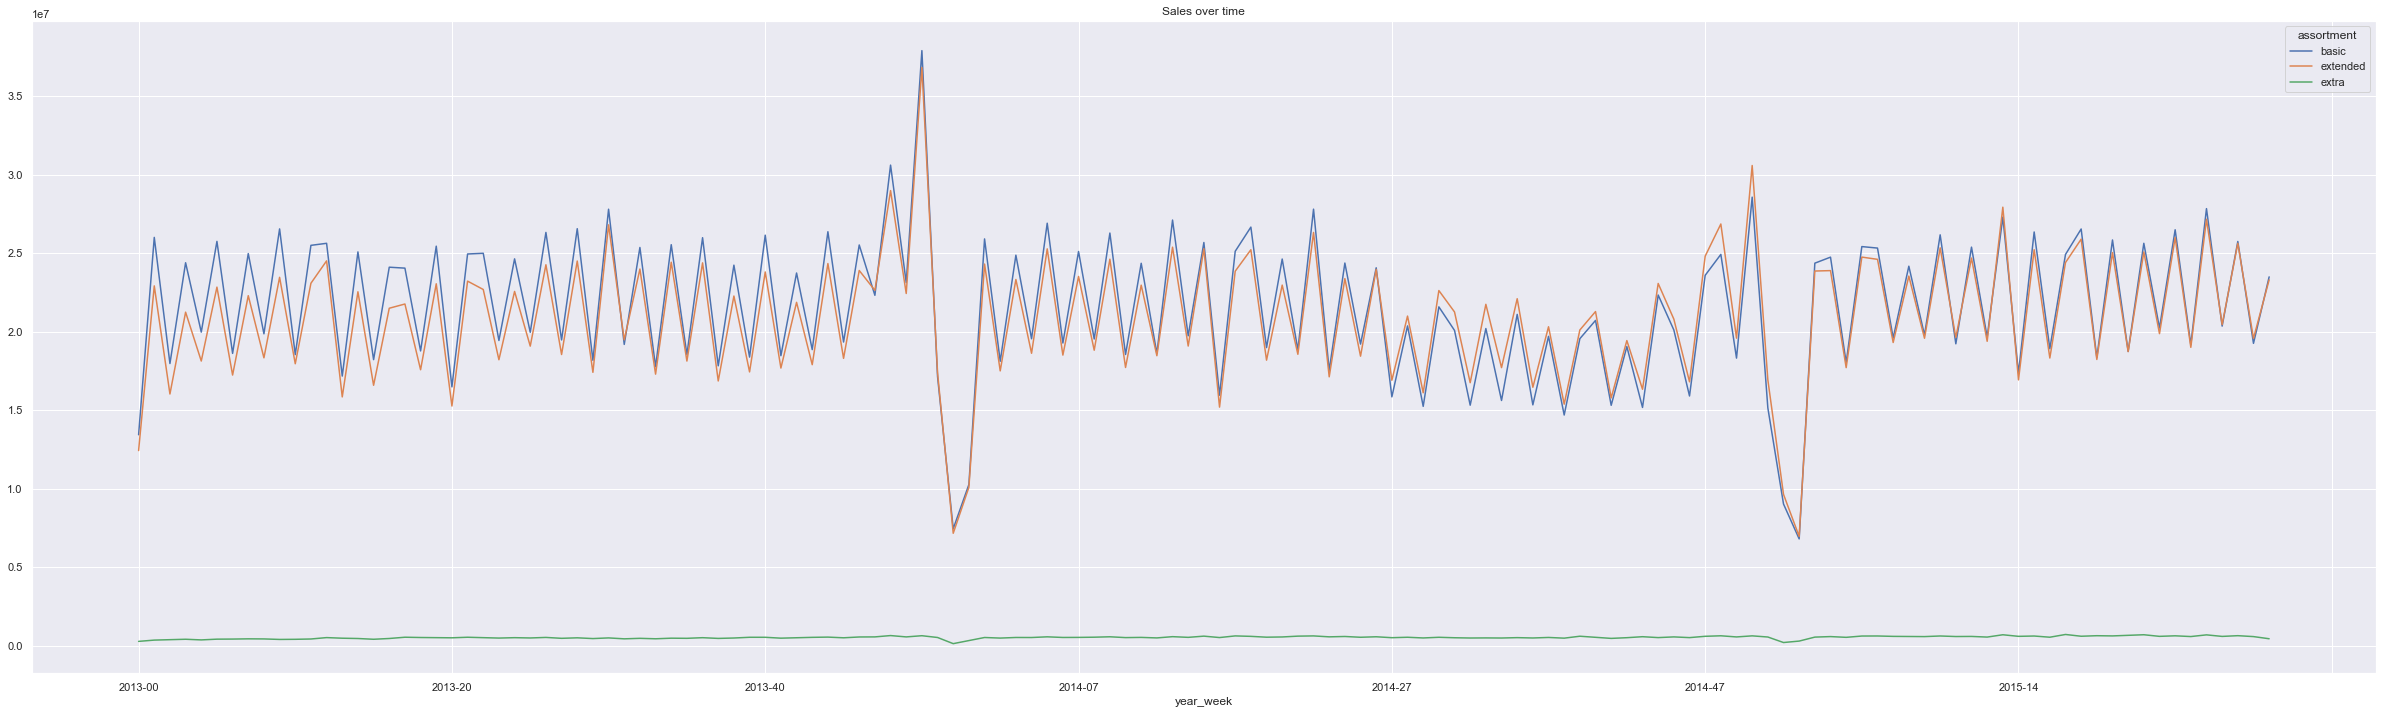

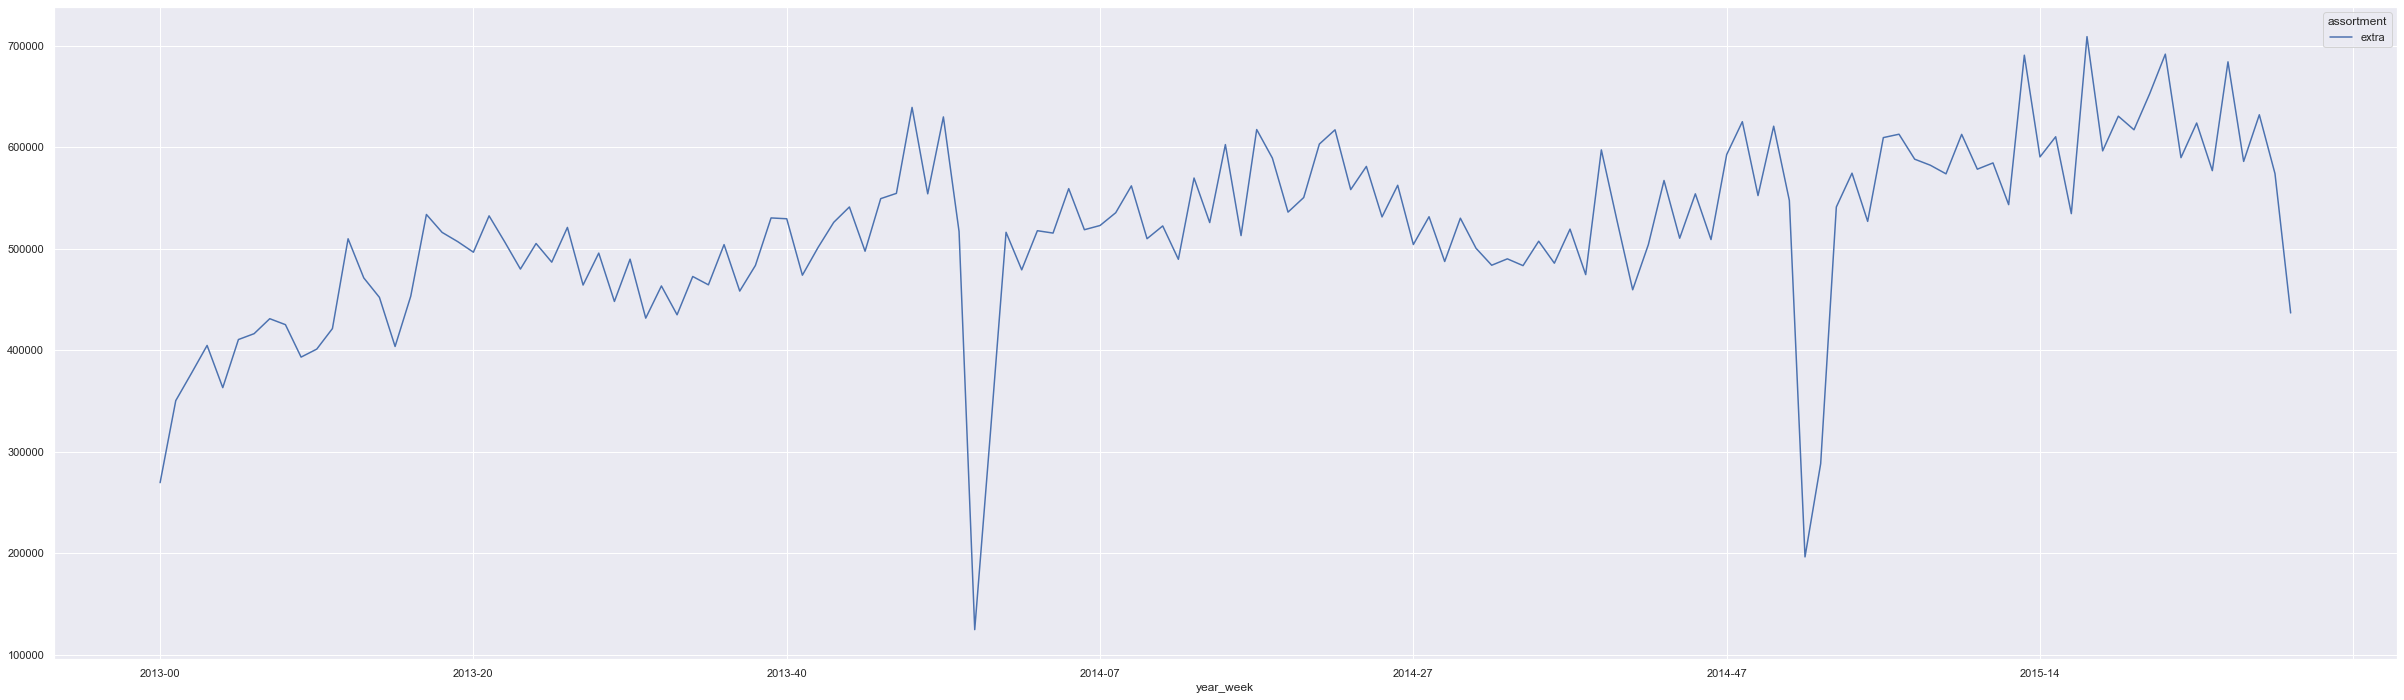

In [28]:
# Checking sales over time (sazonality):
sns.set(rc={'figure.figsize':(42,12)})
aux2 = df4[['year_week' ,'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns= 'assortment', values= 'sales').plot().set_title('Sales over time');

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns= 'assortment', values = 'sales').plot();

### H2. Stores with closer competitors should sell less.

**False.** Stores with closer competitors sell more.

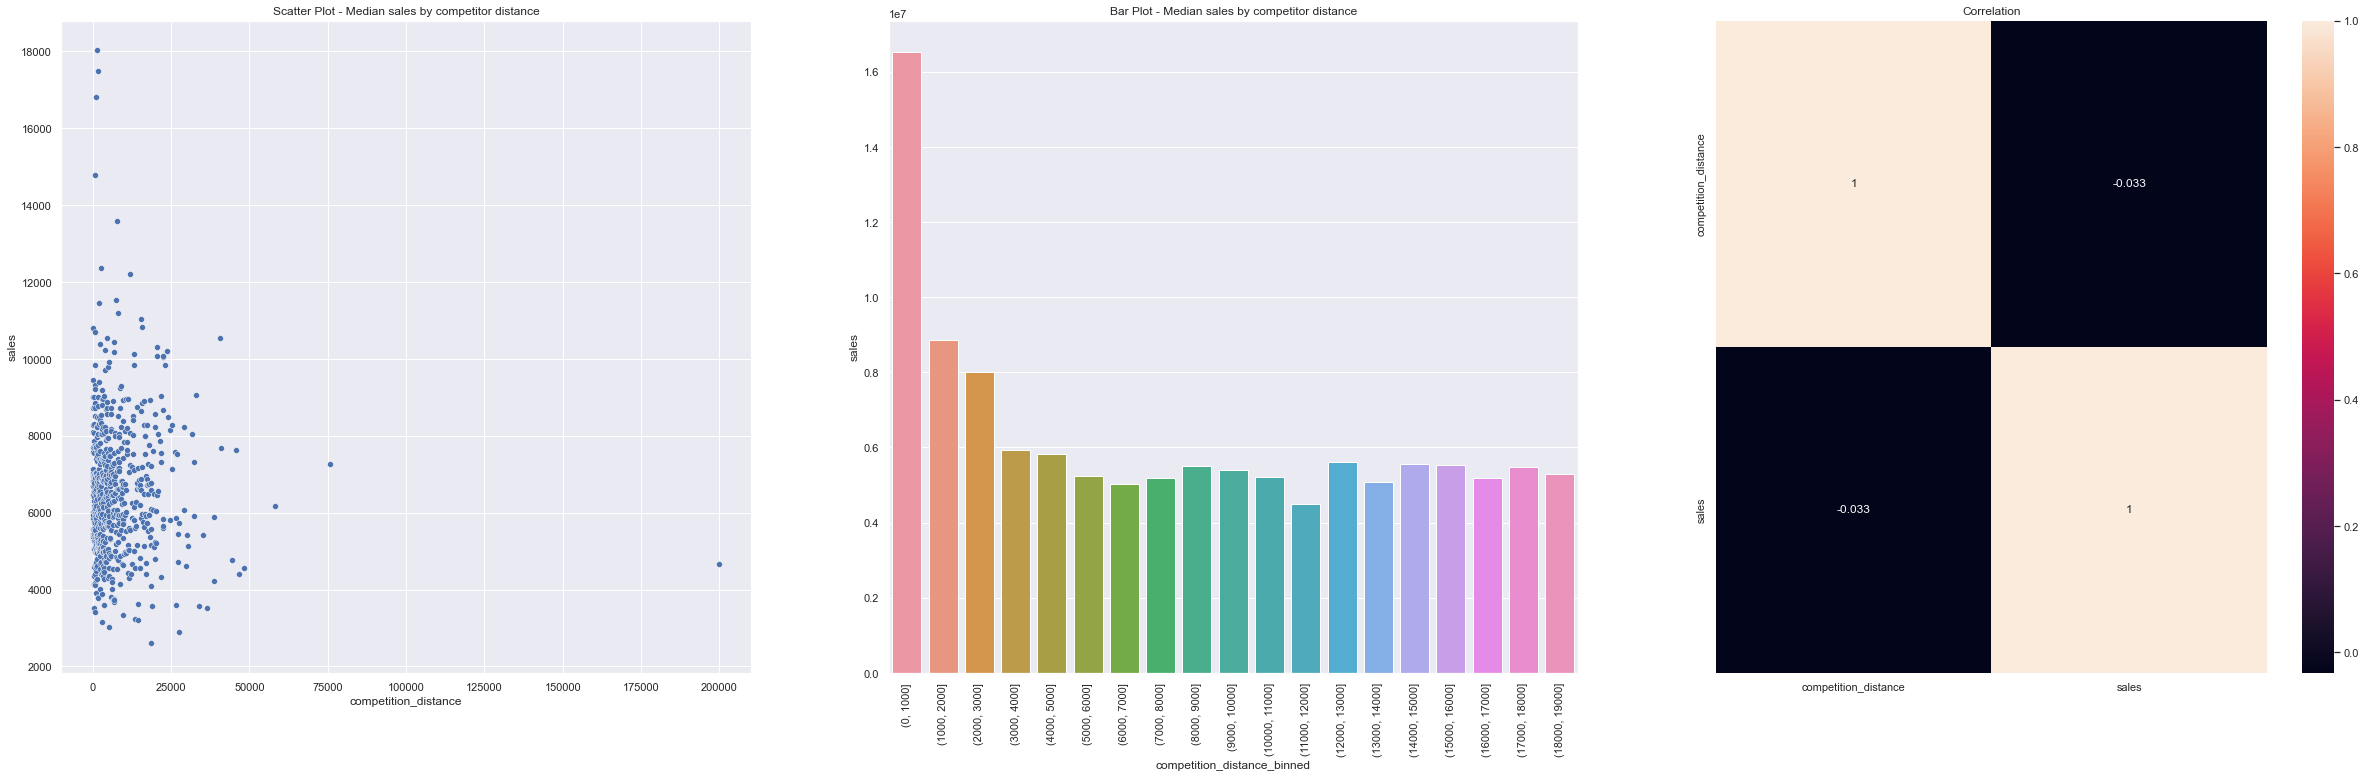

In [29]:
# scatter plot:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data= aux1).set_title('Scatter Plot - Median sales by competitor distance');

# Barplot:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = np.arange(0, 20000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Bar Plot - Median sales by competitor distance');
plt.xticks( rotation = 90);

# Correlação de Pearson:
plt.subplot(1,3,3)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()
sns.heatmap(aux1.corr(method= 'pearson'), annot= True).set_title('Correlation');

### H3. Stores with longer term competitors should sell more.

**False.** Stores with longer term competitors sell less.

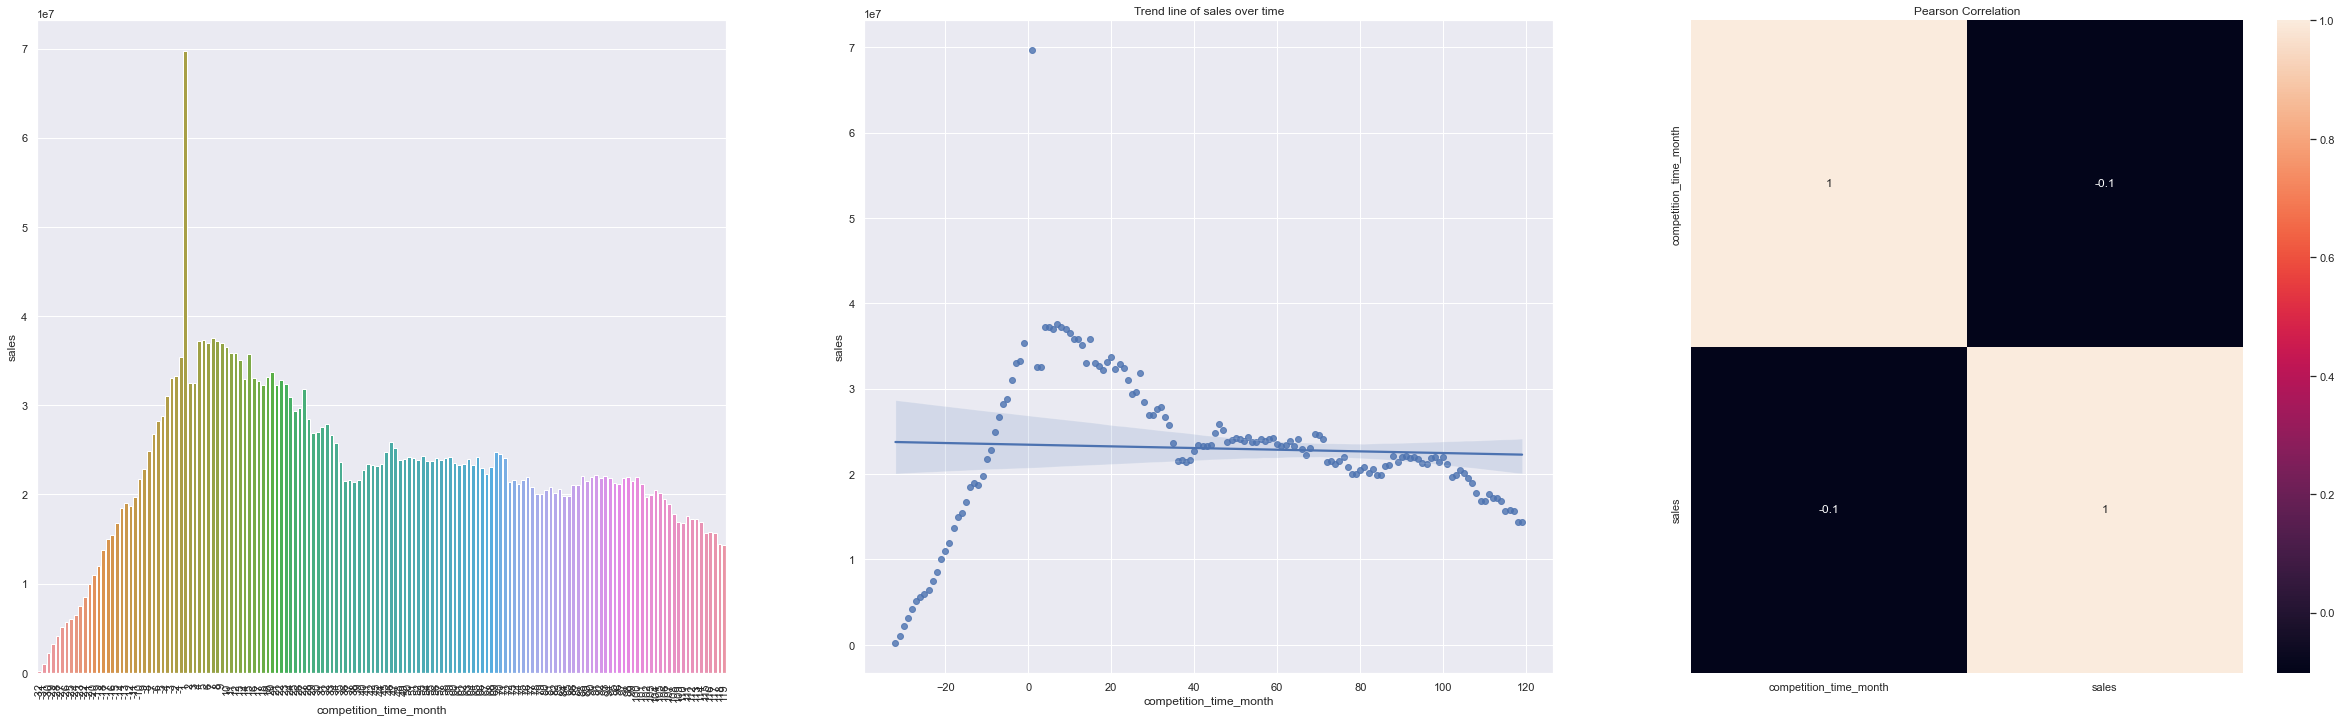

In [30]:
# 'competition_time_month' = sales today - competitor opening month

#my_settings()

# barplot:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# filter:
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);


## regplot: (Just to draw a trendline, beware of bias)
plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= aux2).set_title('Trend line of sales over time');

## heatmap:
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True).set_title('Pearson Correlation');

### **H4.** Stores with promotions active for longer should sell more.

**False.** Stores with promotions active for longer sell less, after a certain promotion period.

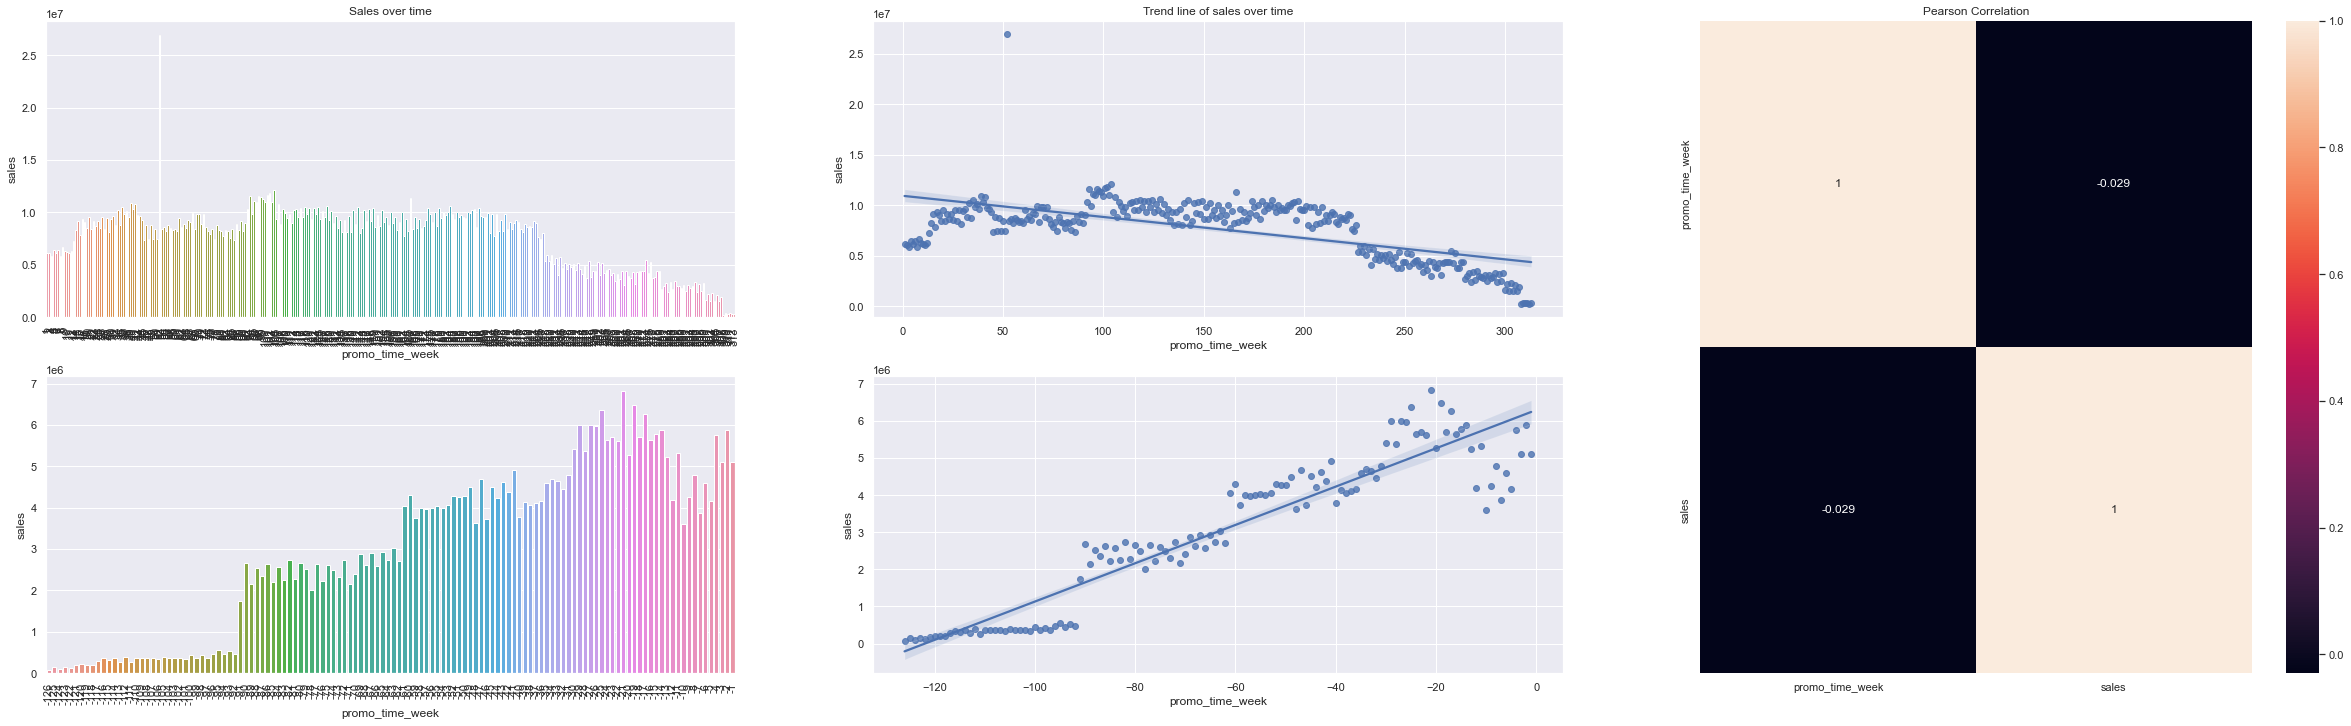

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Grid:
grid = GridSpec(2 , 3) # 2 two rows (0 to 1) e 3 columns (0 to 2)

# barplot promo extended period:
aux2 = aux1[aux1['promo_time_week'] > 0] # → Promo Extended
plt.subplot( grid[0,0] )
sns.barplot( x= 'promo_time_week', y= 'sales', data= aux2).set_title('Sales over time');
plt.xticks(rotation = 90);

# regplot do período de promoções extendidas:
plt.subplot( grid[0,1] )
sns.regplot( x= 'promo_time_week', y= 'sales', data= aux2).set_title('Trend line of sales over time');

# filter to barplot promo extended periods:
aux3 = aux1[aux1['promo_time_week'] < 0] # → Refular Promo traditional
plt.subplot( grid[1,0] )
sns.barplot( x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks(rotation = 90);

# regplot promo traditional:
plt.subplot( grid[1,1] )
sns.regplot( x= 'promo_time_week', y= 'sales', data= aux3);

# heatmap Pearson's Correlation:
plt.subplot(grid[: , 2])
sns.heatmap(aux1.corr(method='pearson'), annot= True).set_title('Pearson Correlation');

### <s> **H5.** Stores with more promotion days should sell more. <s>

**HOLD.** To do on the next CRISP.

### **H6.** Stores with more consecutive promotions should sell more.

**False.** Stores with more consecutive promotions sell less.

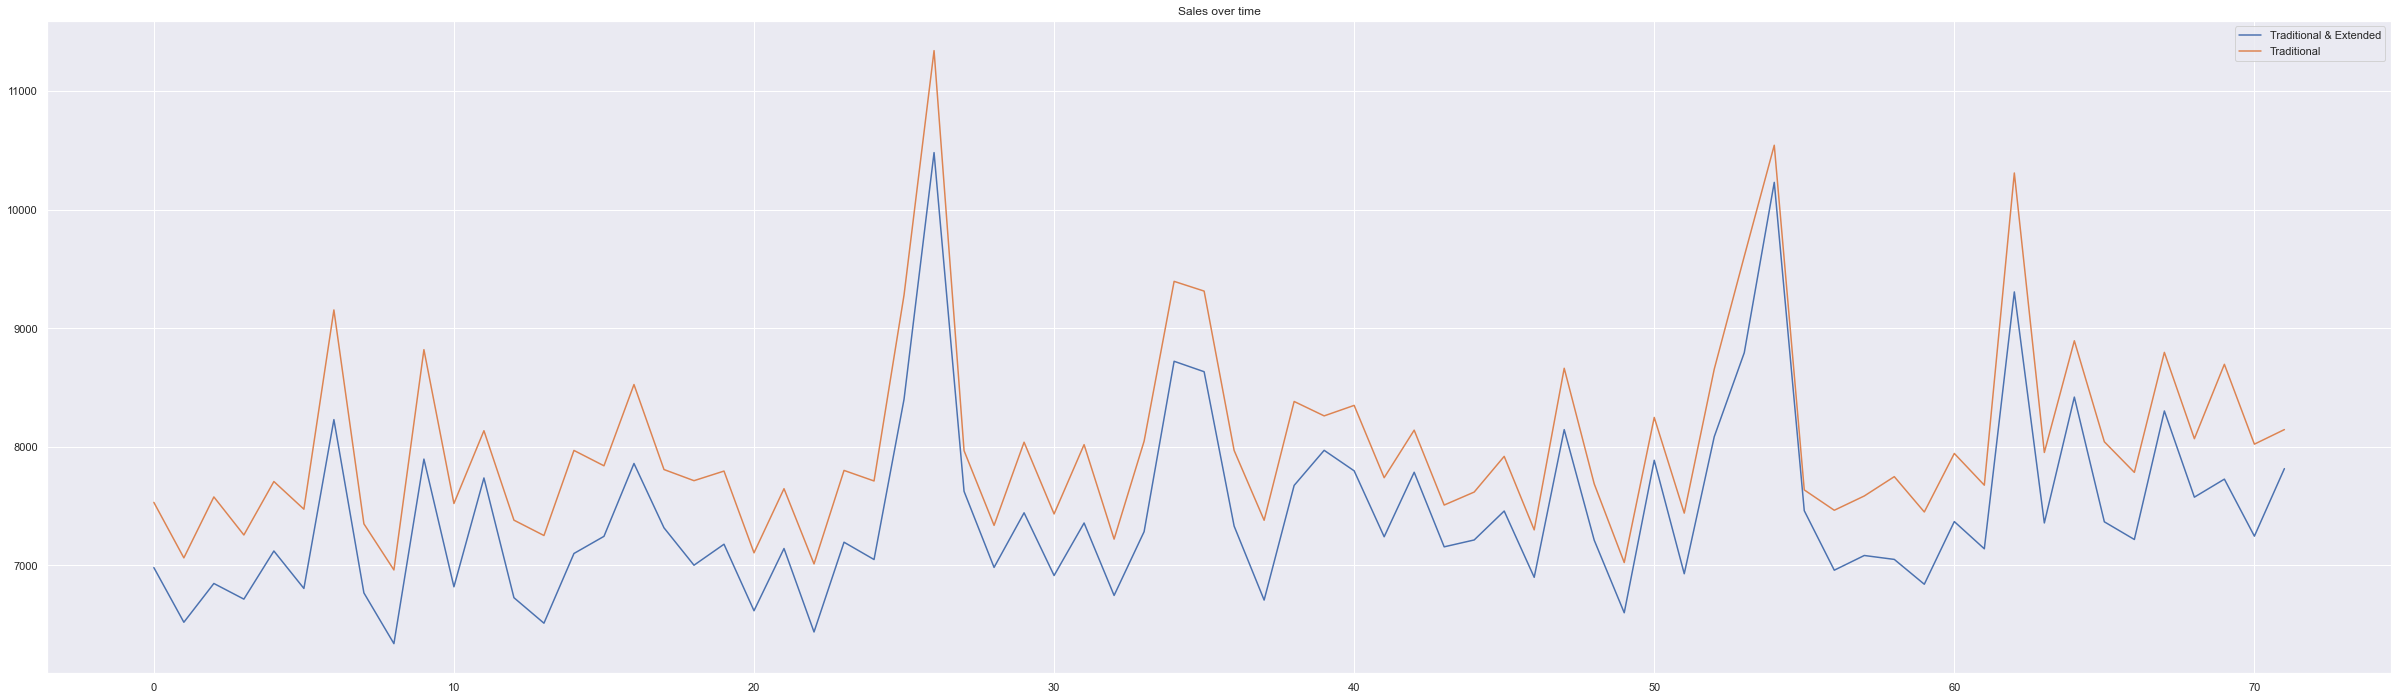

In [32]:
# Stores with two promotional periods:
aux1 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').median().reset_index()
ax1 = aux1.plot();

# Stores with one promotional periods:
aux2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(ax = ax1).set_title('Sales over time');
ax1.legend(labels = ['Traditional & Extended', 'Traditional']);


### **H7.** Stores open during the Christmas holiday should sell more.

**True.** Stores open during the Christmas holiday sell more.

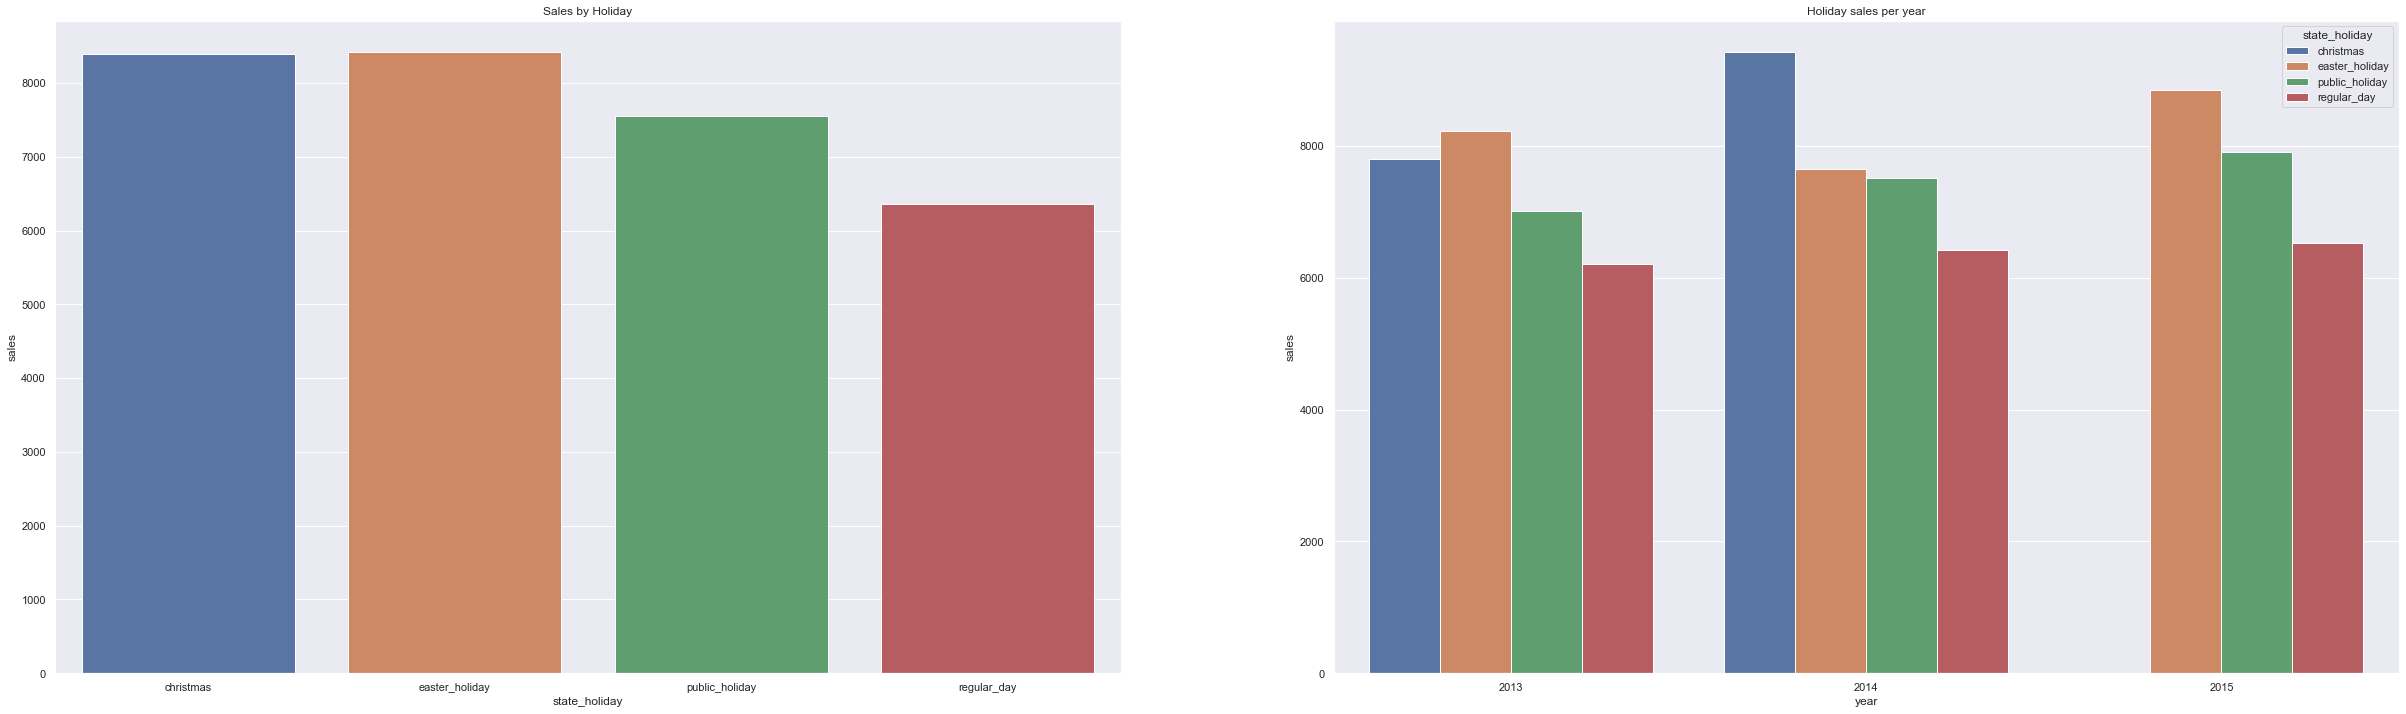

In [33]:
# Filter dataset:
aux = df4[df4['state_holiday'] != 'regular_day']

# median of sales
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
# barplot:
plt.subplot(1,2,1);
sns.barplot(x= 'state_holiday', y='sales', data=aux1).set_title('Sales by Holiday');

# barplot por ano (tentar pegar um efeito sazonal):
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
plt.subplot(1,2,2);
sns.barplot(x = 'year', y= 'sales', hue= 'state_holiday', data= aux2).set_title('Holiday sales per year');

### **H8.** Stores should sell more over the years.

**True.** Stores sell more over the years.

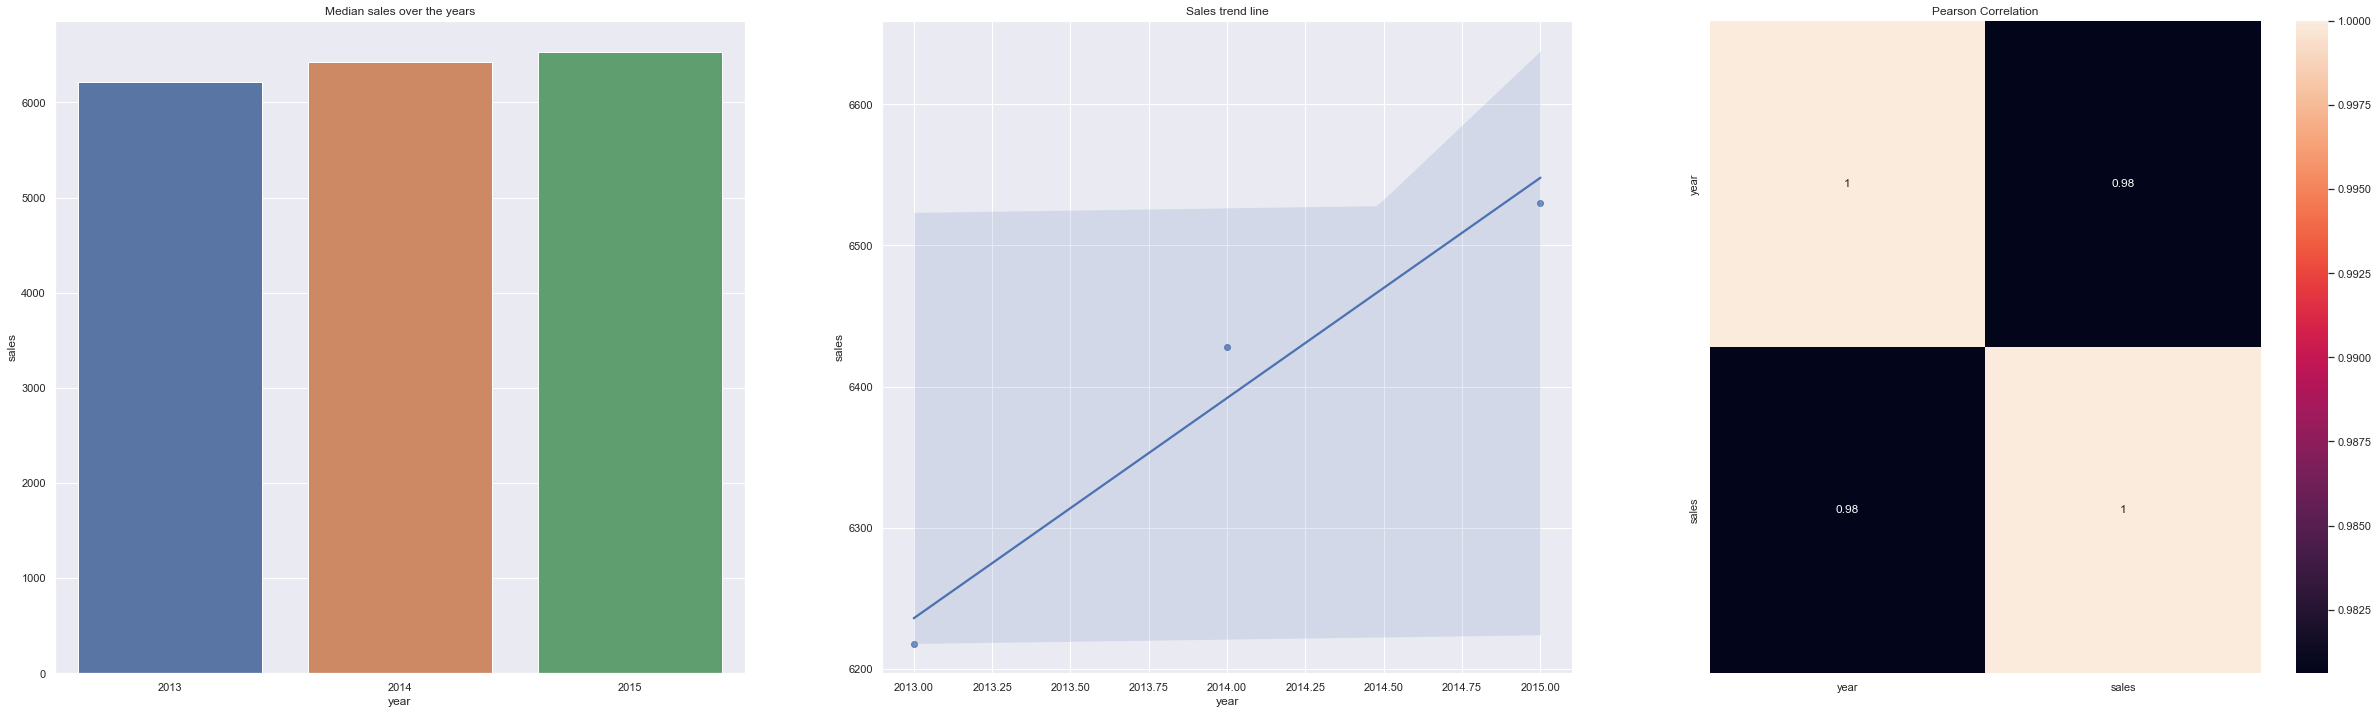

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()

# barplot:
plt.subplot(1,3,1);
sns.barplot(x= 'year', y='sales', data= aux1).set_title('Median sales over the years');

# Trendline:
plt.subplot(1,3,2);
sns.regplot(x= 'year', y='sales', data= aux1).set_title('Sales trend line');

# heatmap de correlação: Obs.: 2015 ainda não é um ano fechado o que aumenta essa correlação
plt.subplot(1,3,3);
sns.heatmap(aux1.corr(method= 'pearson'), annot= True).set_title('Pearson Correlation');

### **H9.** Stores should sell more in the second half of the year.

**True.** Stores sell more in the second half of the year.


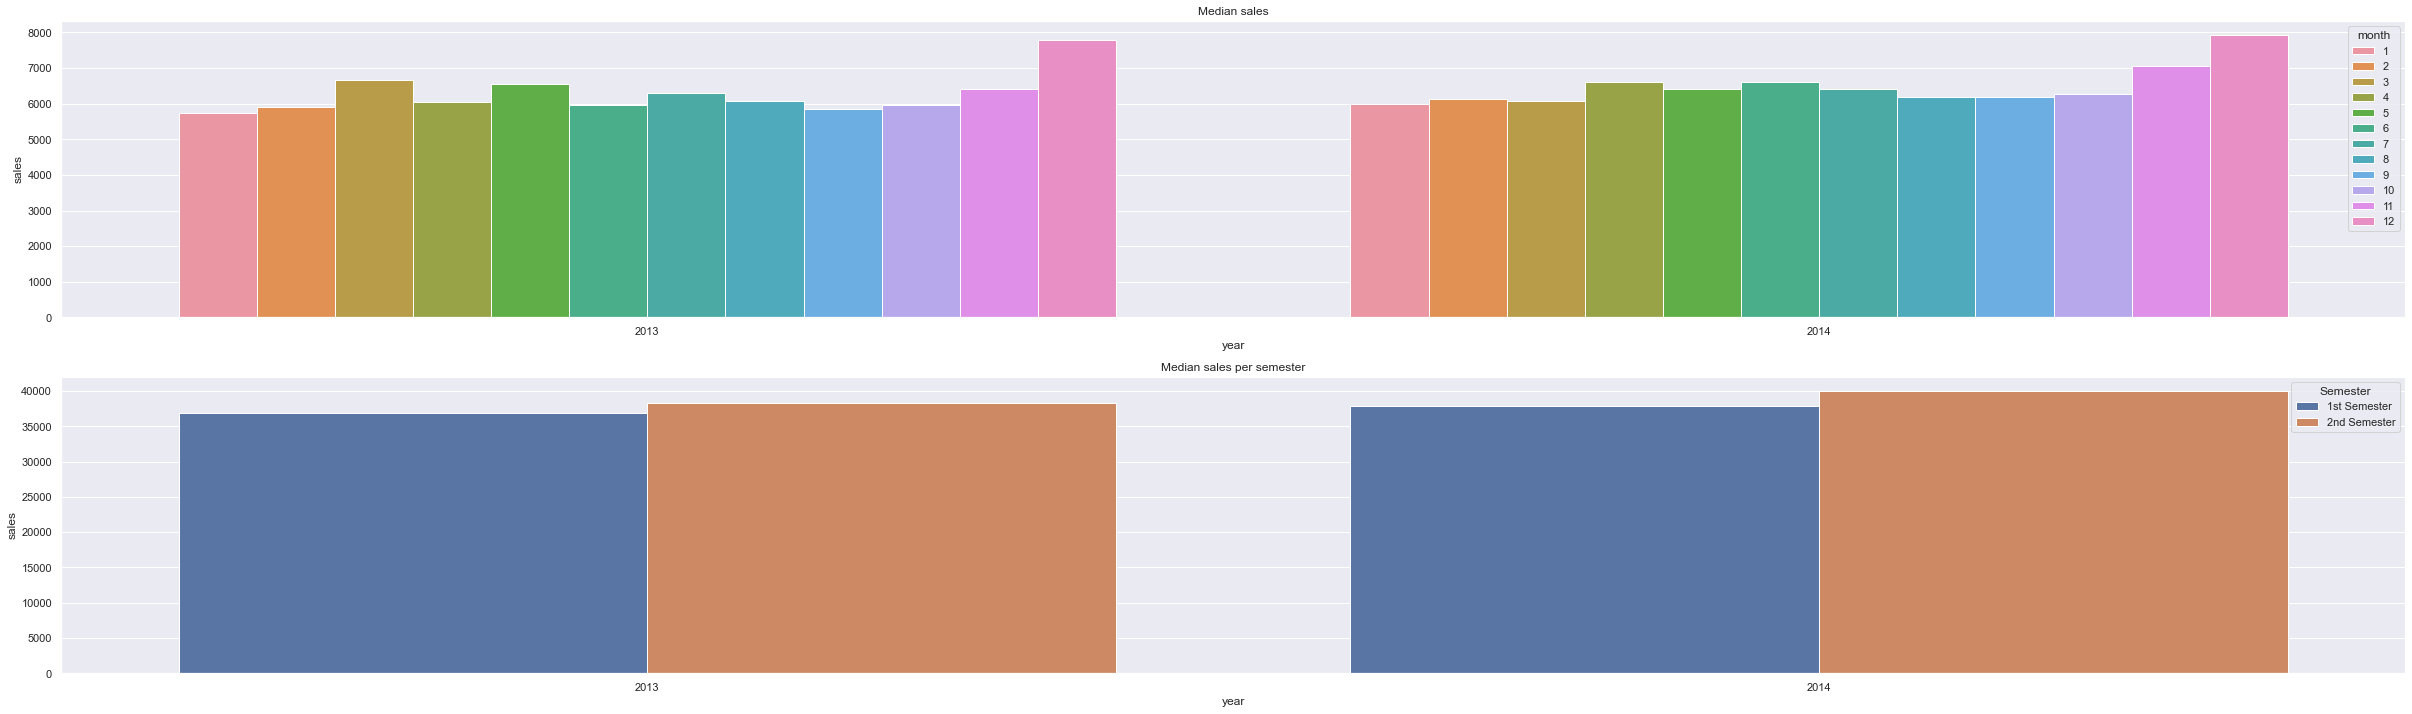

In [35]:
# 2015 is not complete to analysis, filter year:
aux1 = df4[df4['year'] < 2015]

aux1 = aux1[['year', 'month', 'sales']].groupby(['year', 'month']).median().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'year', y= 'sales', hue= 'month', data= aux1).set_title('Median sales');

#
#filter:
aux1 = df4[df4['year'] < 2015]

# Median
aux1 = aux1[['year', 'month', 'sales']].groupby(['year', 'month']).median().reset_index()

# split aux1 by semesters:
bins = np.arange(0, 13, 6)
aux1['semester'] = pd.cut(aux1['month'], bins = bins)

aux2 = aux1[['year', 'semester', 'sales']].groupby(['year', 'semester']).sum().reset_index()
plt.subplot(2,1,2)
labels=['1st Semester', '2nd Semester']
ax = sns.barplot(x = 'year', y = 'sales', hue = 'semester', data = aux2)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Semester")
plt.title('Median sales per semester')
plt.show()


### **H10.** Stores should sell more after the 10th of each month.

**False**. On average, stores sell less after the 10th day of each month.

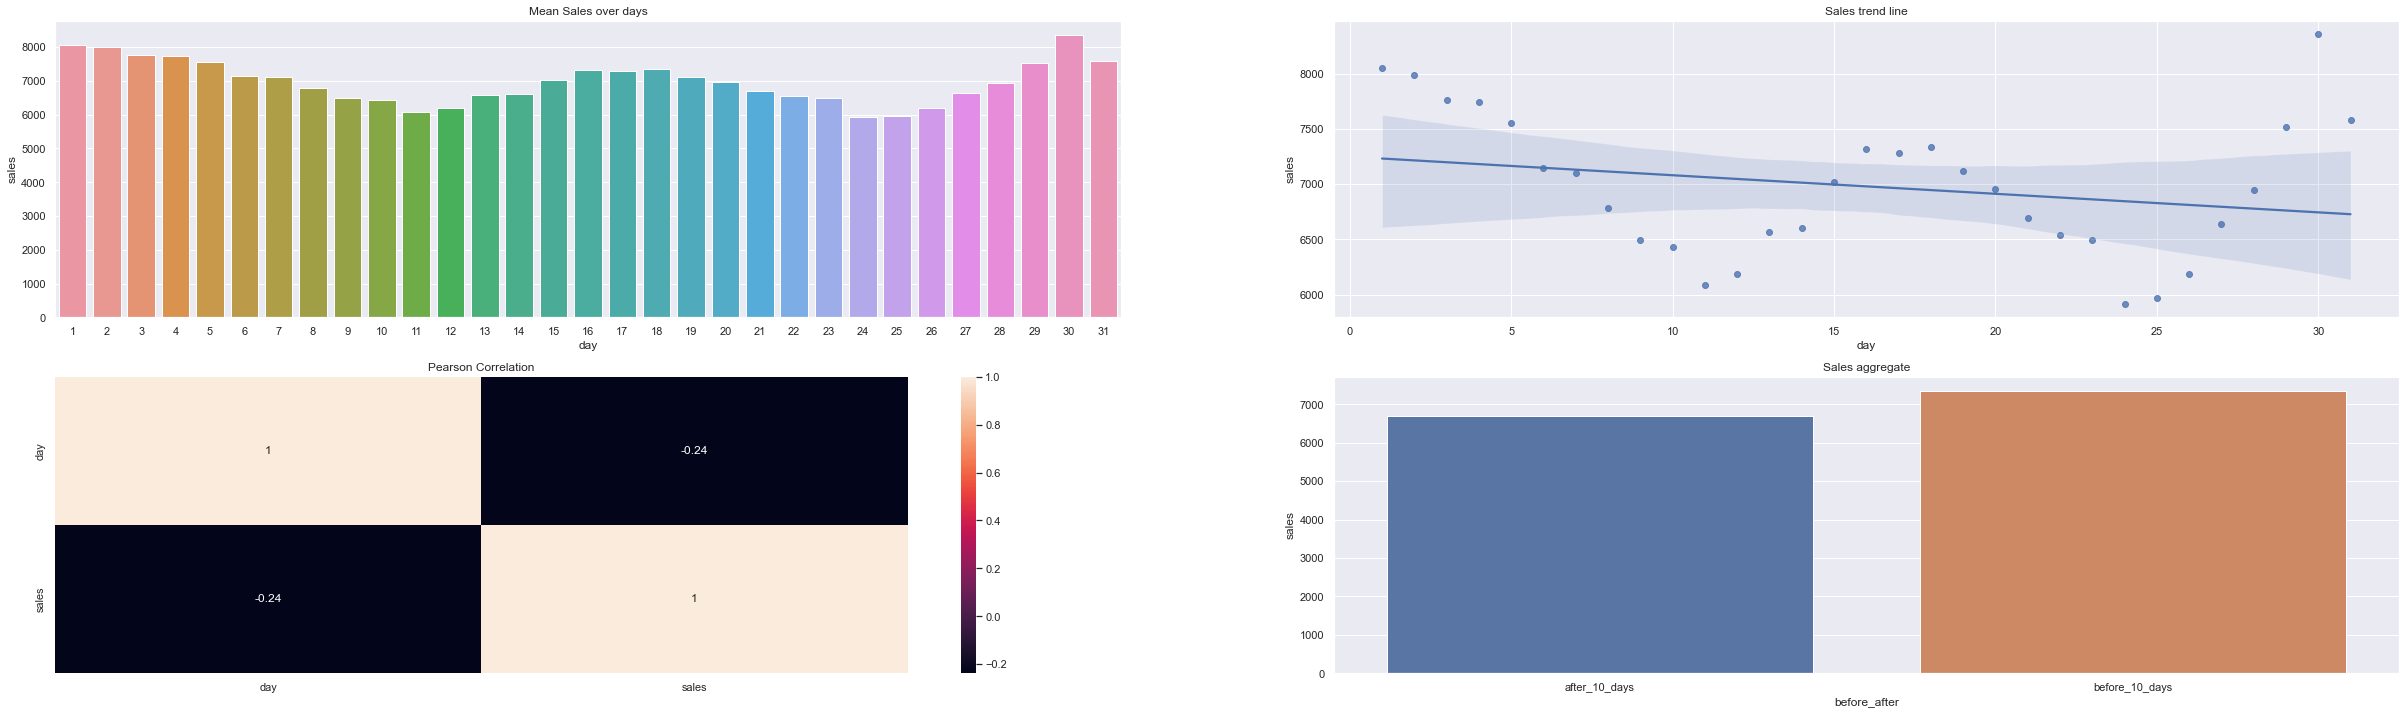

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

# barplot:
plt.subplot(2,2,1);
sns.barplot(x= 'day', y='sales', data= aux1).set_title('Mean Sales over days');

# regplot trend line:
plt.subplot(2,2,2);
sns.regplot(x= 'day', y='sales', data= aux1).set_title('Sales trend line');

# Correlation heatmap:
plt.subplot(2,2,3);
sns.heatmap(aux1.corr(method= 'pearson'), annot= True).set_title('Pearson Correlation');

# sales before and after 10th day:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').median().reset_index()

plt.subplot(2,2,4);
sns.barplot(x='before_after', y= 'sales', data=aux2).set_title('Sales aggregate');

### **H11.** Stores should sell less on weekends.

**False.** Stores sell more on weekends.

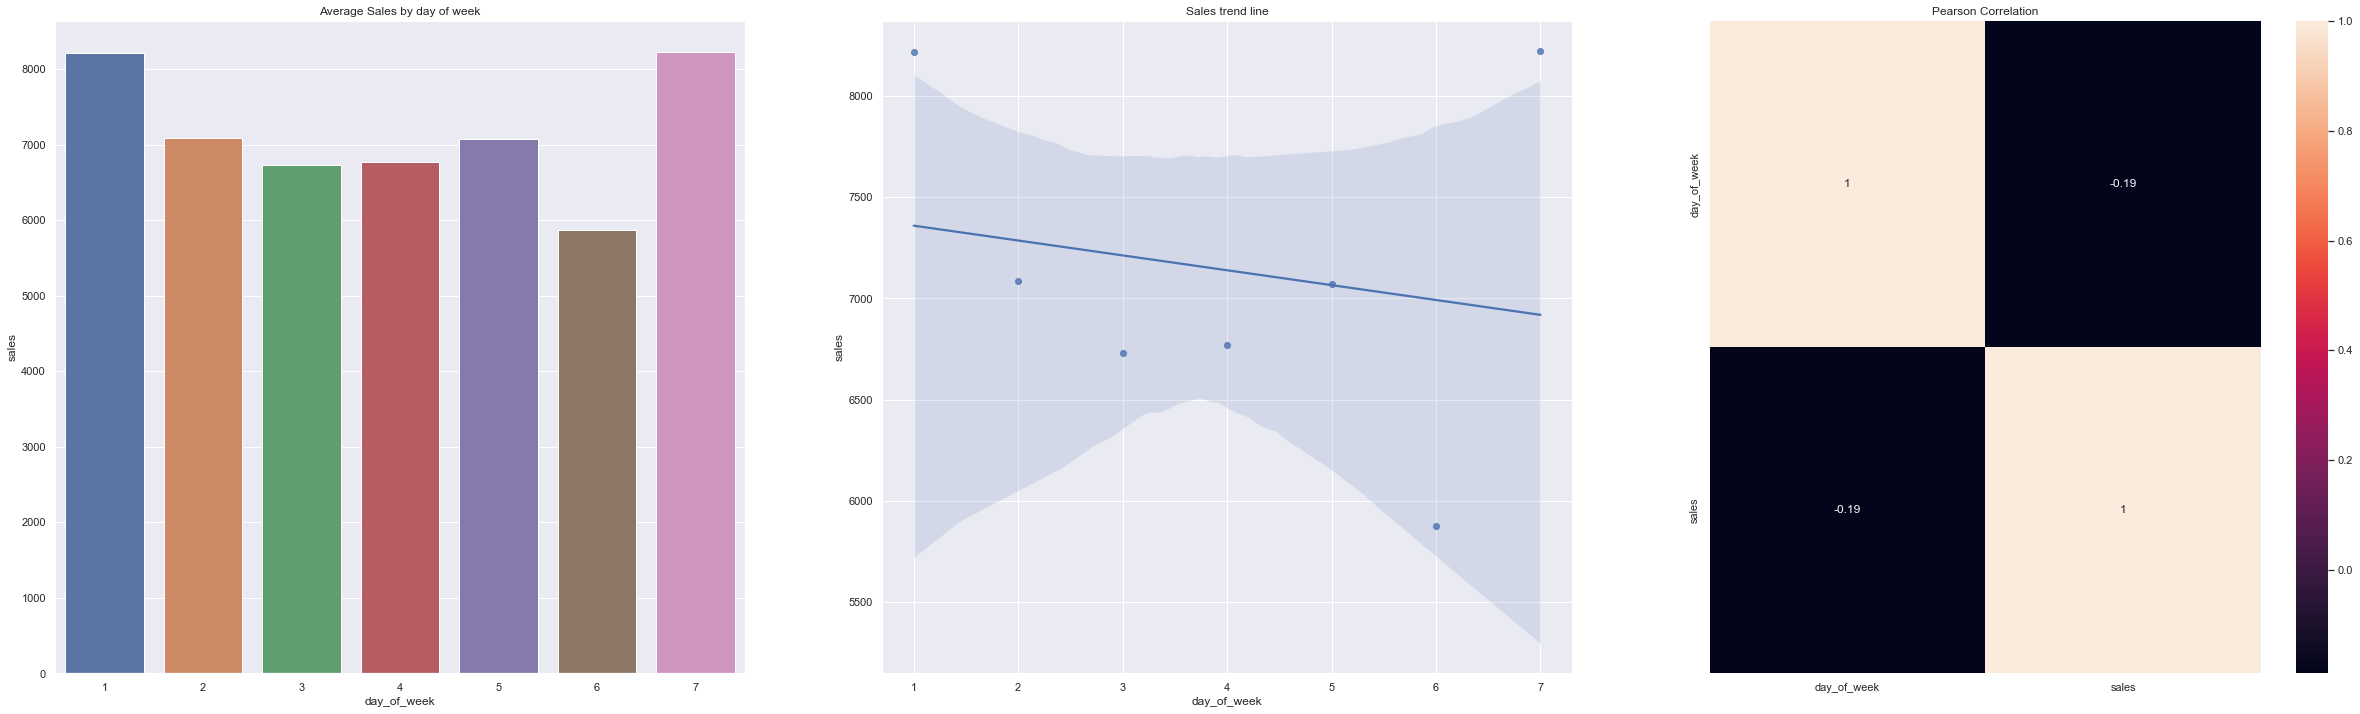

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

# barplot:
plt.subplot(1,3,1);
sns.barplot(x= 'day_of_week', y='sales', data= aux1).set_title("Average Sales by day of week");

# regplot trend line:
plt.subplot(1,3,2);
sns.regplot(x= 'day_of_week', y='sales', data= aux1).set_title("Sales trend line");

# Pearson Correlation Heatmap:
plt.subplot(1,3,3);
sns.heatmap(aux1.corr(method= 'pearson'), annot= True).set_title("Pearson Correlation");

### **H12.** Stores should sell less during school holidays.

**False**. Stores sell more during school holidays.

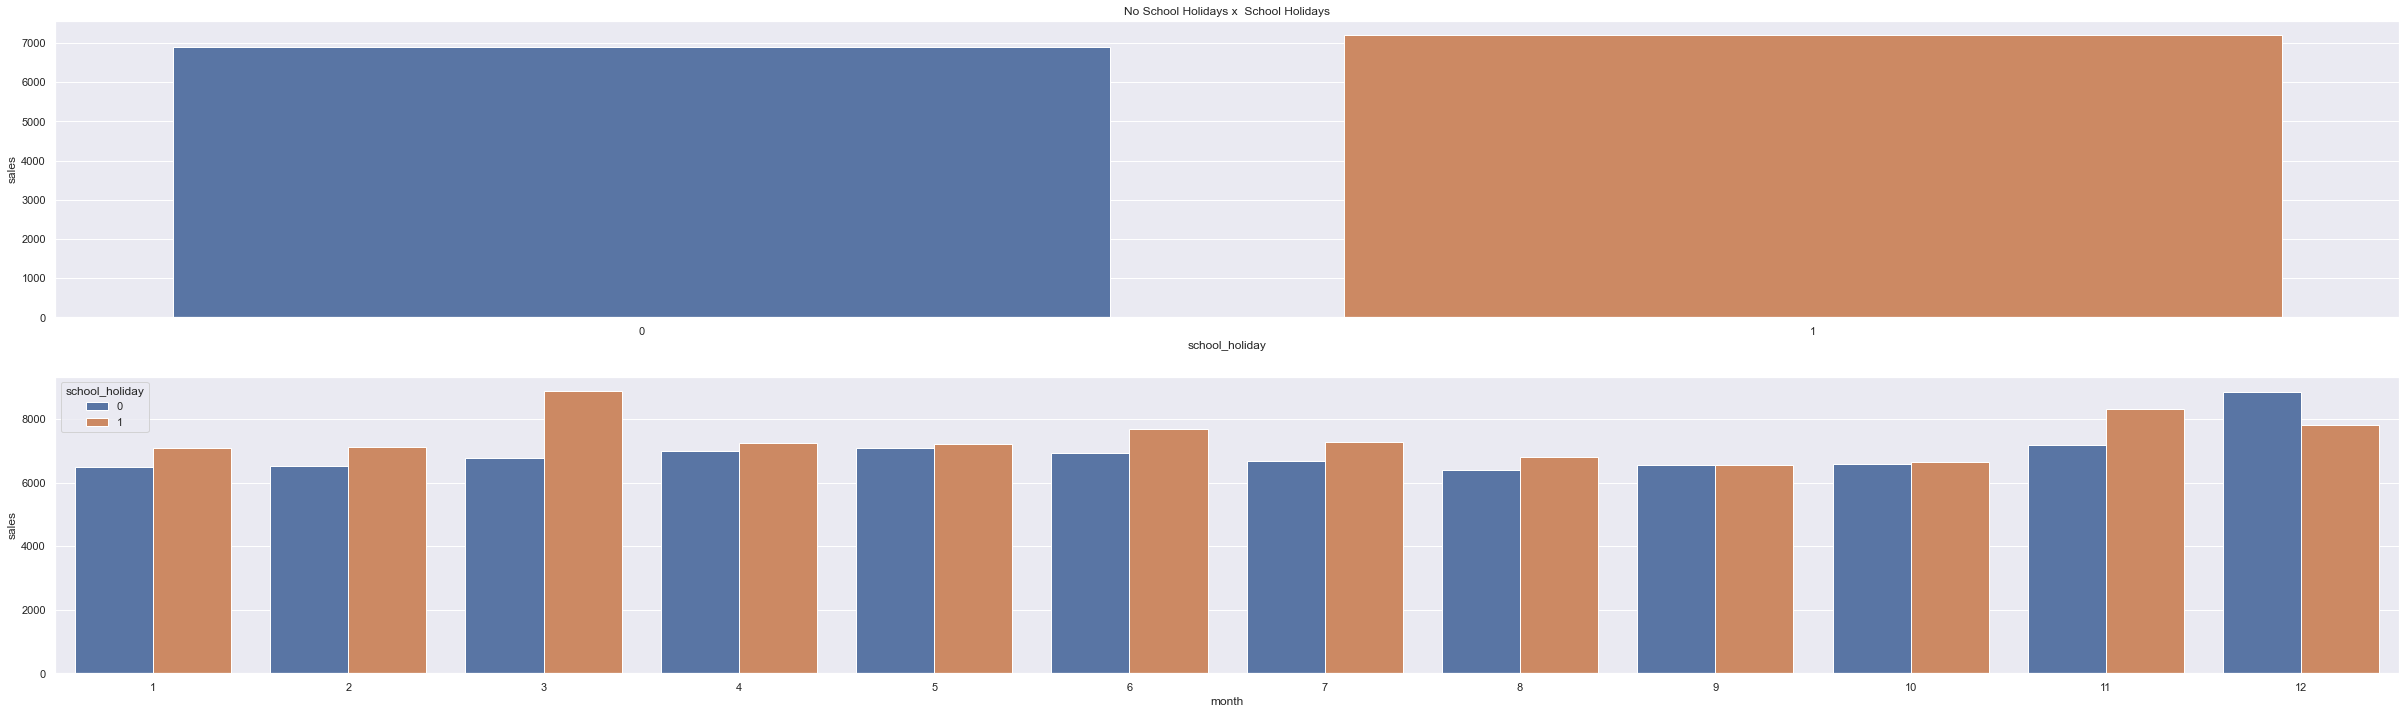

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# barplot:
plt.subplot(2,1,1);
sns.barplot(x= 'school_holiday', y='sales', data= aux1).set_title('No School Holidays x  School Holidays');

# barplot by month:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
plt.subplot(2,1,2);
sns.barplot(x='month', y='sales', hue='school_holiday', data= aux2);

### Summary table of the Hypothesis Test

In [39]:
df_summary = pd.DataFrame( {'Hypothesis': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'],
                           'Conclusion' : ['True', 'False', 'False', 'False', 'Hold', 'False', 'True', 'True', 'True', 'False', 'False', 'False'],
                            'Relevance' : ['Low', 'Medium', 'Medium', 'Medium', '-', 'Low', 'Medium', 'High', 'High', 'High', 'High', 'Medium'  ],
                            'Feature'   : ['assortment', 'competition_distance', 'competition_time_month', 'promo_time_week', '-', 'promo2', 'state_holiday', 'year', 'month', 'day', 'day_of_week', 'school_holiday' ]
                           }
                            
                         )
df_summary

,Hypothesis,Conclusion,Relevance,Feature
0,H1,True,Low,assortment
1,H2,False,Medium,competition_distance
2,H3,False,Medium,competition_time_month
3,H4,False,Medium,promo_time_week
4,H5,Hold,-,-
5,H6,False,Low,promo2
6,H7,True,Medium,state_holiday
7,H8,True,High,year
8,H9,True,High,month
9,H10,False,High,day


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

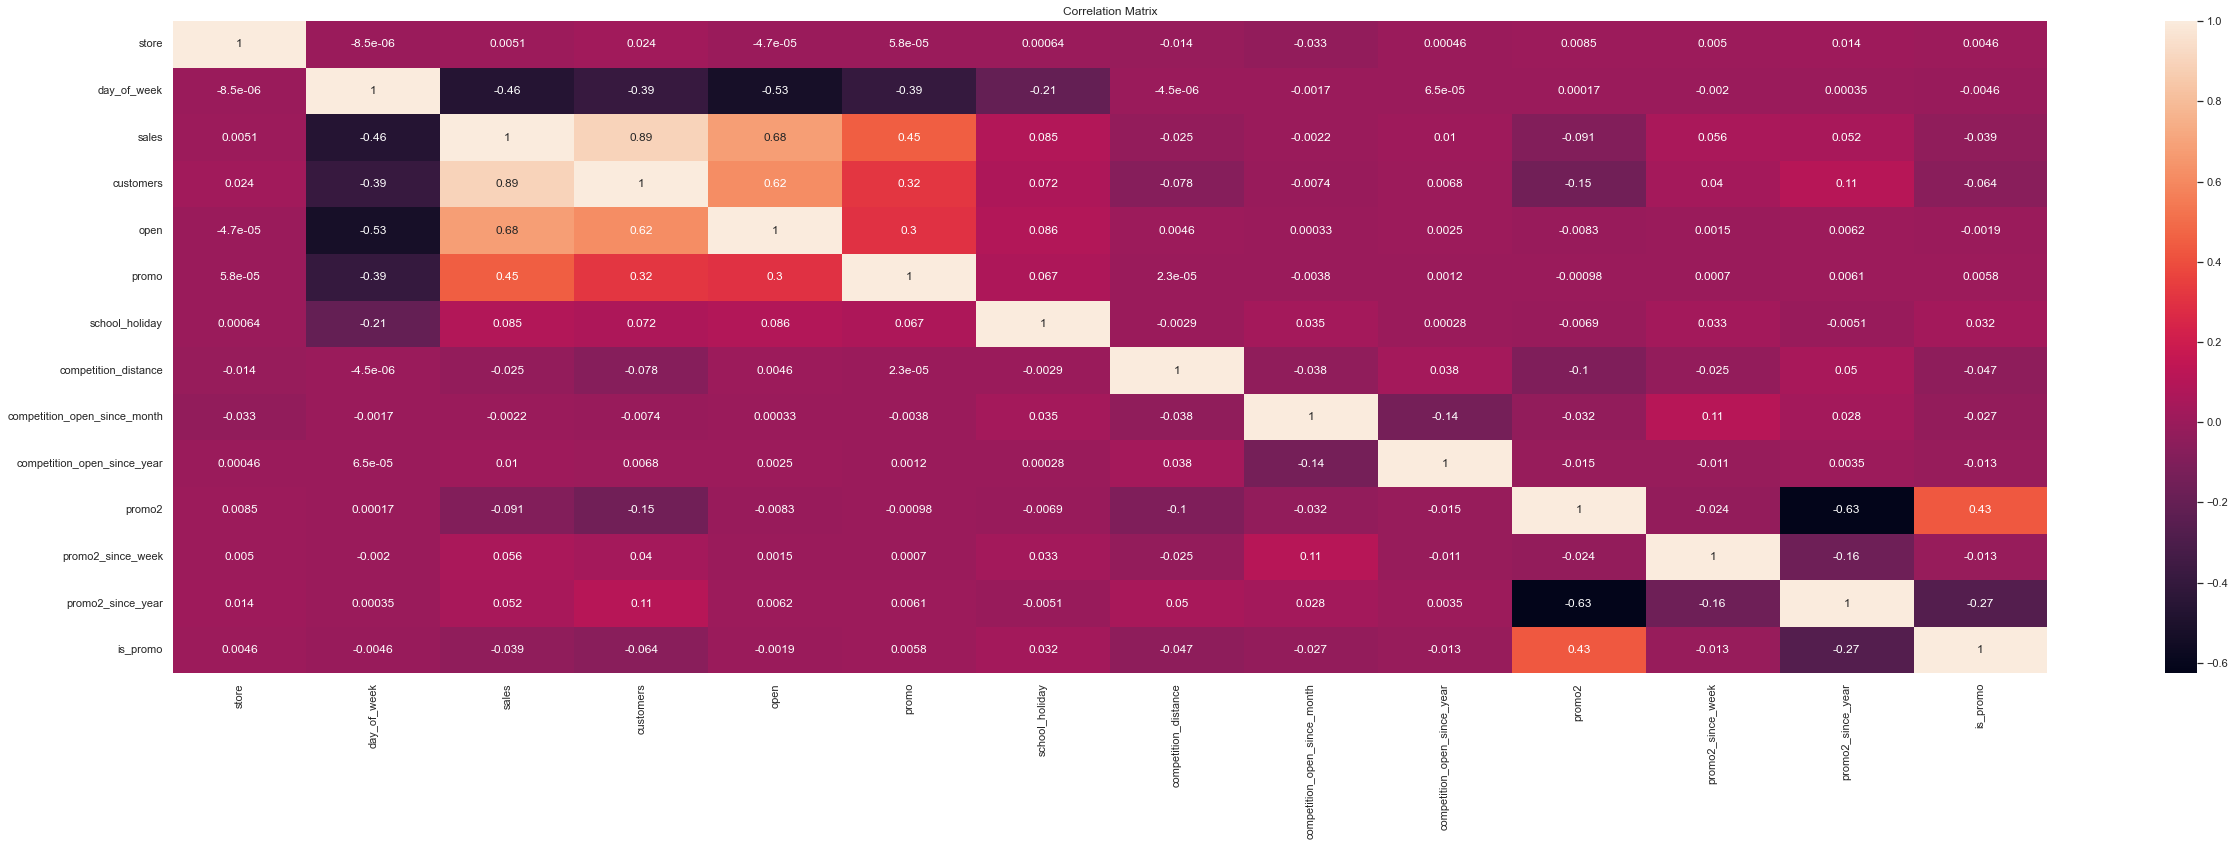

In [40]:
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot= True).set_title('Correlation Matrix');

### 4.3.2. Categorical Attributes

In [41]:
# Get only categorical data:
a = df4.select_dtypes(include='object')[['state_holiday', 'store_type', 'assortment']]
a.head(3)

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic


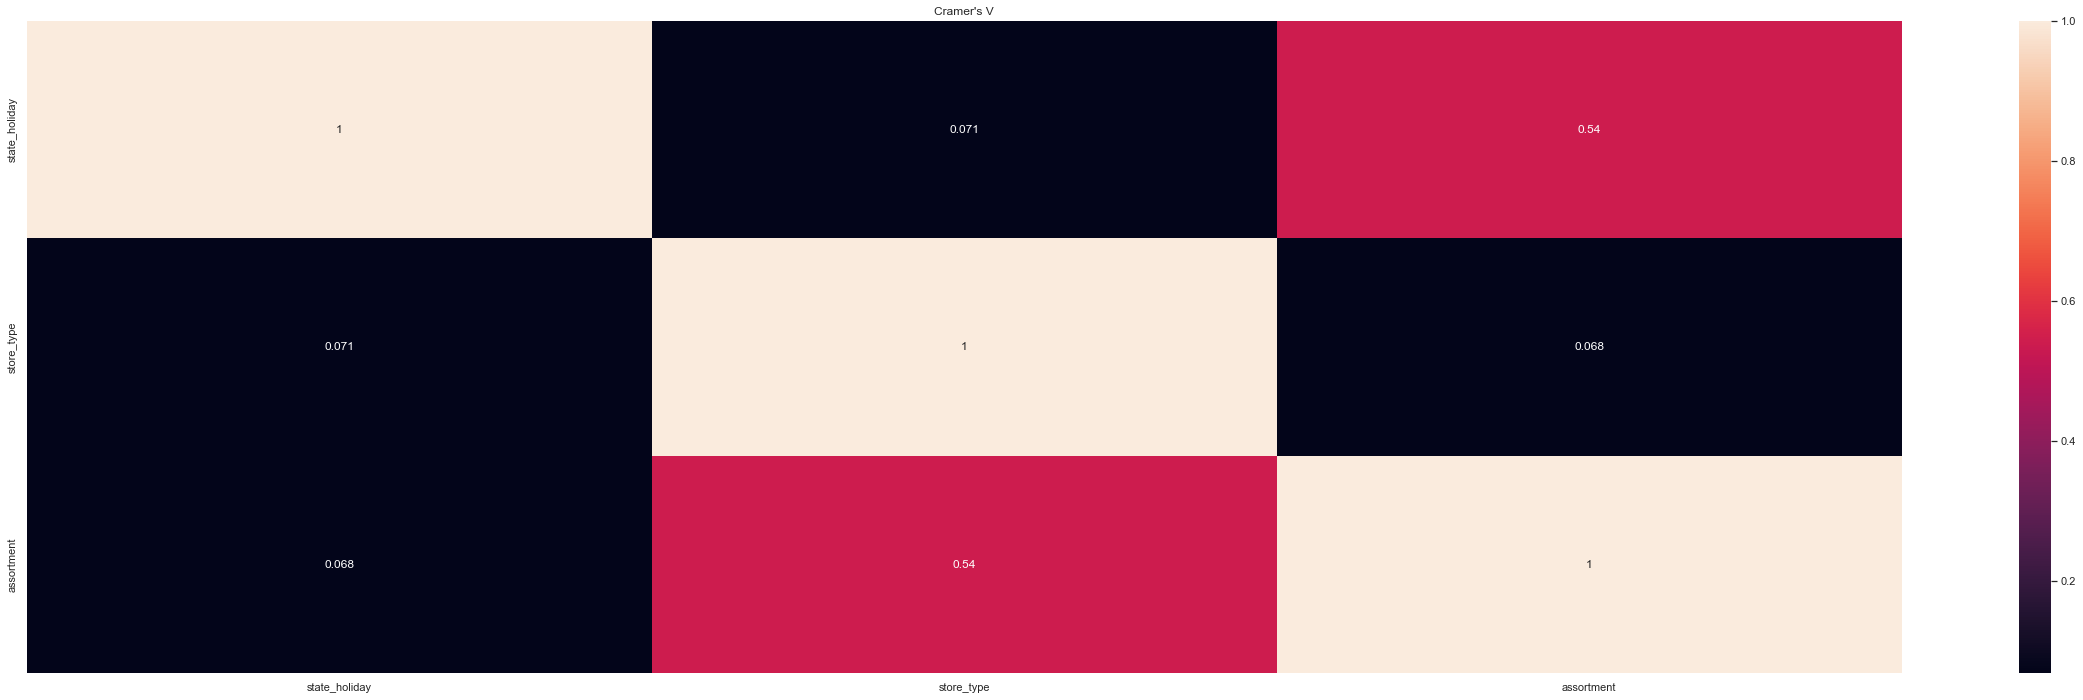

In [42]:
# Dataframe para plotar heatmap de correlação:

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday']  )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['store_type'])
a8 = cramer_v( a['assortment'], a['state_holiday'] )
a9 = cramer_v( a['assortment'], a['assortment'])


# final dataset:
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                      'store_type': [a4, a5, a6],
                      'assortment': [a7, a8, a9] 
              } )

d = d.set_index(d.columns)

# create heatmap Cramér's V Correlation:
sns.heatmap(d, annot= True).set_title("Cramer's V");

# 5.0. STEP 05: DATA PREPARATION

In [43]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [44]:
a = df5.select_dtypes( include = ['int64', 'float64'])
a

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.00,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.00,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.00,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.00,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.00,4,2015,0,31,2015,0,2015,7,31,31,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.00,9,2006,0,1,2013,0,2013,1,1,1,77,0
1016827,733,2,10765,0,1,860.00,10,1999,0,1,2013,0,2013,1,1,1,161,0
1016863,769,2,5035,0,1,840.00,1,2013,1,48,2012,1,2013,1,1,1,0,6
1017042,948,2,4491,0,1,1430.00,1,2013,0,1,2013,0,2013,1,1,1,0,0


For features with many outliers we will opt for the Robust Scaler method. The others MinMax Scaler


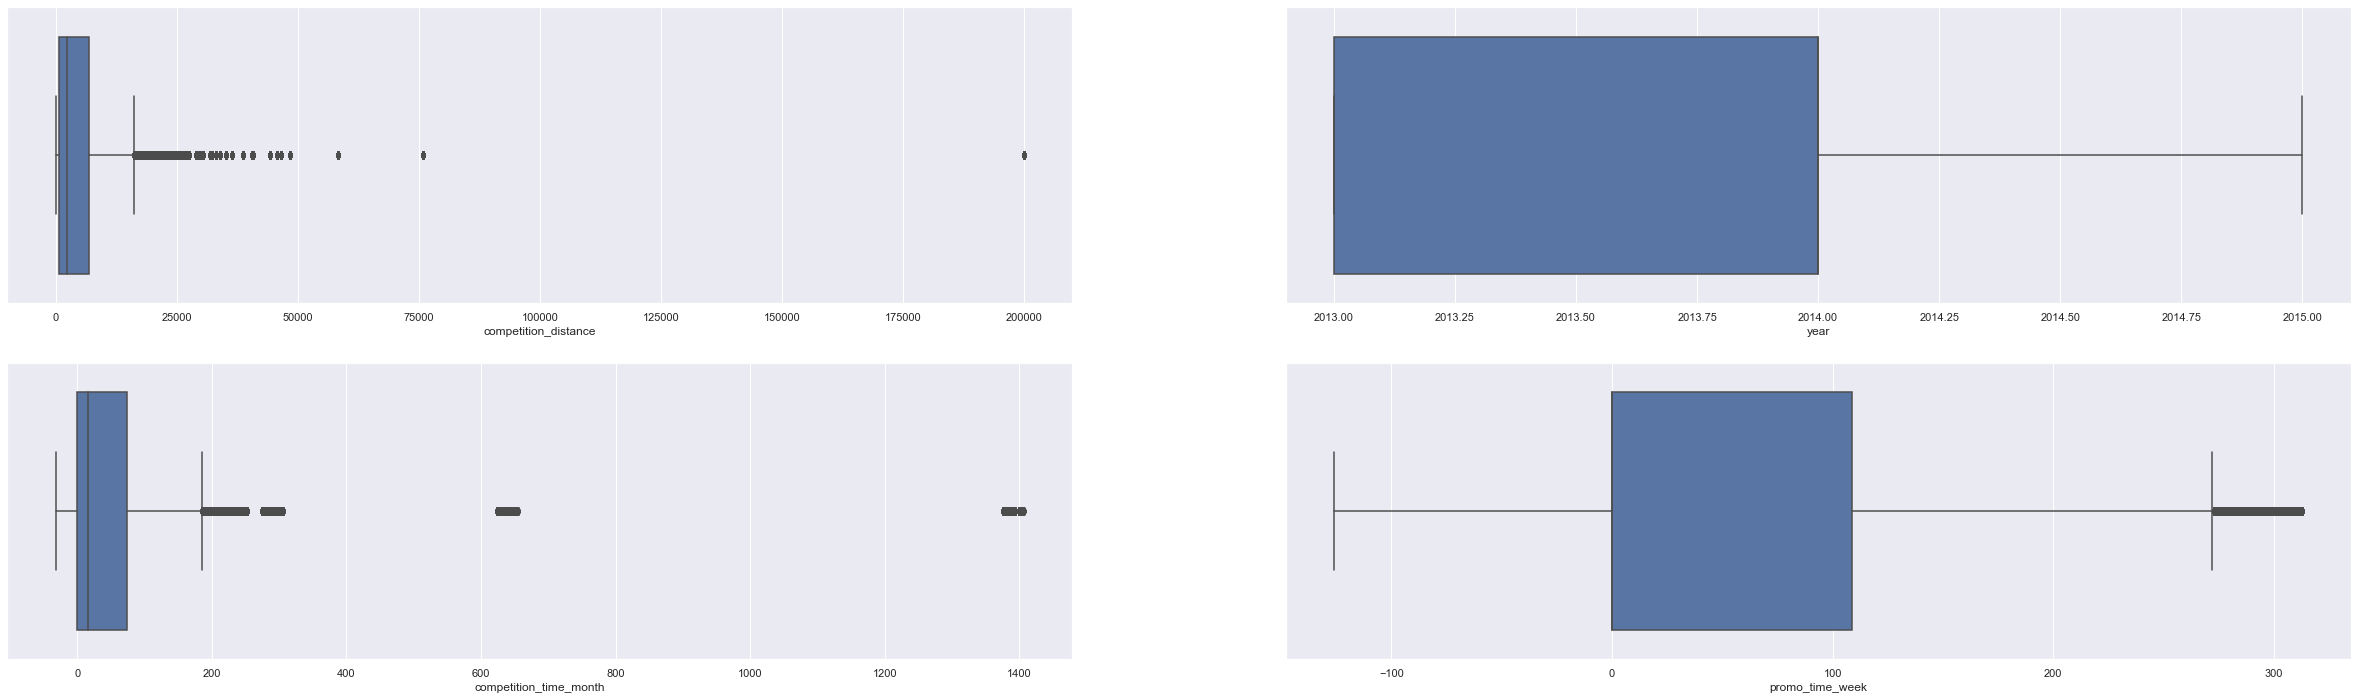

In [45]:
# Checking outliers using boxplot:
plt.subplot(2,2,1);
sns.boxplot(x = df5['competition_distance'], orient= 'h');

plt.subplot(2,2,2);
sns.boxplot(x = df5['year'], orient= 'h');

plt.subplot(2,2,3);
sns.boxplot(x = df5['competition_time_month'], orient= 'h');

plt.subplot(2,2,4);
sns.boxplot(x = df5['promo_time_week'], orient= 'h');


print('For features with many outliers we will opt for the Robust Scaler method. The others MinMax Scaler')

In [46]:
# instantiate the class to use it:
rs = RobustScaler()
mms = MinMaxScaler()

# rescaling competition distance:
df5['competition_distance'] =  rs.fit_transform(df5[['competition_distance']].values)

# rescaling competition time month:
df5['competition_time_month'] =  rs.fit_transform(df5[['competition_time_month']].values)

# rescaling promo time week:
df5['promo_time_week'] =  mms.fit_transform(df5[['promo_time_week']].values)

# rescaling competition distance:
df5['year'] =  mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [47]:
# state_holiday → One Hot Encoding:
df5 = pd.get_dummies(data = df5, prefix= ['state_holiday'], columns= ['state_holiday'])

# store_type → Label Encoding:
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment → Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [48]:
# Log Transform:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [49]:
print("For cyclical variables, let's apply transformations. Are they: \n\n• day of week\n• month\n• day\n• week of year")


For cyclical variables, let's apply transformations. Are they: 

• day of week
• month
• day
• week of year


In [50]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 ) )  )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi/7 ) )  )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2 * np.pi/12 ) )  )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2 * np.pi/12 ) )  )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2 * np.pi/30 ) )  )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2 * np.pi/30 ) )  )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi/52 ) )  )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi/52 ) )  )

In [53]:
df5.shape

(844338, 36)

In [52]:
# save data:
#df5.to_csv('df5.csv', sep= ';', header=True, index = False)

# 6.0 STEP 06: FEATURE SELECTION

In [54]:
df6 = df5.copy()
#df6 = pd.read_csv('df5.csv', delimiter=';')

## 6.1 Split original DataFrame into train and test

In [55]:
# Columns date to date format:
df6['date'] = pd.to_datetime(df6['date'])

# Delete auxiliary variables
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6.drop( cols_drop, axis=1, inplace=True)

# Important dates:
print( f"Fisrt date: {df6['date'].min().date()}")
print( f"Fisrt date: {df6['date'].max().date()}")
print( f"6 weeks is equivalent to {datetime.timedelta(days=6*7)}")

Fisrt date: 2013-01-01
Fisrt date: 2015-07-31
6 weeks is equivalent to 42 days, 0:00:00


In [56]:
# Split data into train and test:
# last day - 42 days → split date: 2015-06-19
cut_date = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 7 * 6)

# split the dataset into train and test:
df6_train = df6[df6['date'] < cut_date]
df6_test = df6[df6['date'] >= cut_date]

# split the training set:
X_train = df6_train.drop(['sales', 'date'], axis=1)
y_train = df6_train['sales']

# split the test set:
X_test = df6_test.drop(['date', 'sales'], axis=1)
y_test = df6_test['sales']

## 6.2. Boruta as Feature Selector

In [ ]:
# Instance Random Forest Regressor using all nucleus of processor:
#rf = RandomForestRegressor(n_jobs=-1)

In [ ]:
## Boruta works with arrays as inputs:
#X_train_array = X_train.values
#y_train_array = y_train.values.ravel()
#
## Define Boruta:
#boruta = BorutaPy( estimator= rf, n_estimators= 'auto', verbose= 2, random_state= 42 ).fit( X_train_array, y_train_array )

### 6.2.1 Best Features from Boruta

In [ ]:
# Seleceted features by relevance:
#cols_selected = boruta.support_.tolist() #rank of relevance

#best features
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [ ]:
# cols_selected_boruta

In [ ]:
# cols_not_selected_boruta

In [57]:
### Columns selected by Boruta Algorithm:
cols_selected_by_boruta = ['store',
                           'promo',
                           'store_type',
                           'assortment',
                           'competition_distance',
                           'competition_open_since_month',
                           'competition_open_since_year',
                           'promo2',
                           'promo2_since_week',
                           'promo2_since_year',
                           'competition_time_month',
                           'promo_time_week',
                           'day_of_week_sin',
                           'day_of_week_cos',
                           'month_cos',
                           'day_sin',
                           'day_cos',
                           'week_of_year_cos']

### Cols not selected by Boruta:
cols_not_selected_by_boruta = ['is_promo',
                               'month_sin',
                               'school_holiday',
                               'state_holiday_christmas',
                               'state_holiday_easter_holiday',
                               'state_holiday_public_holiday',
                               'state_holiday_regular_day',
                               'week_of_year_sin',
                               'year']

## 6.3. Manual Feature Selection

In [58]:
# Cols selected by Boruta more some manual features: 'week_of_year_sin' and 'day_of_week_cos'
cols_selected_boruta = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

# columns to add:
feat_to_add = ['date', 'sales']

# add feat_to_add elements to final features:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [214]:
# Final list of features:
print(cols_selected_boruta_full)

pd.DataFrame({'All Features':cols_selected_boruta})

None


,All Features
0,store
1,promo
2,store_type
3,assortment
4,competition_distance
5,competition_open_since_month
6,competition_open_since_year
7,promo2
8,promo2_since_week
9,promo2_since_year


# 7.0. STEP 07: MACHINE LEARNING MODELS

In [134]:
x_train = df6_train[cols_selected_boruta]
# y_train was defined in session 6.1

x_test = df6_test[cols_selected_boruta]
# y_train was defined in session 6.1

## 7.1. Average Model

In [160]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Average Predictions:
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# performance (não esquecer de voltar a variável resposta ao formato original tirar o exponencial):
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


## 7.2. Linear Regression Model

In [161]:
# model
lr = LinearRegression().fit(x_train, y_train)
# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


## 7.3. Linear Regression Regularized Model - Lasso

In [137]:
# model
lrr = Lasso(alpha= 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


## 7.4. Random Forest Regressor

In [183]:
# model
rf = RandomForestRegressor( n_estimators= 100, n_jobs=-1, random_state= 42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.46,0.10,1007.92


## 7.5. XGBoost Regressor

In [185]:
# model
model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',  
                              n_estimators= 100,
                              eta= 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytee = 0.9).fit(x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,854.16,0.12,1262.76


## 7.6. Compare Models Performance

In [186]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.46,0.10,1007.92
0,XGBoost Regressor,854.16,0.12,1262.76
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1891.70,0.29,2744.45


## 7.8. Cross Validation - The Real Performance of ML Models

In [70]:
# select data to pass for cross_validation function:
# the cross_validation function split into "k" mutually exclusive subsets of the same size (training and validation)
x_training = df6_train[cols_selected_boruta_full]

### 7.8.1. Linear Regression - Cross-Validation

In [73]:
model = LinearRegression()

lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', model, verbose = True)
lr_result_cv


KFold Number: 5
          Model Name     MAE  MAPE    RMSE
0  Linear Regression 2646.81  0.31 3821.90

KFold Number: 4
          Model Name     MAE  MAPE    RMSE
0  Linear Regression 1908.47  0.33 2576.46

KFold Number: 3
          Model Name     MAE  MAPE    RMSE
0  Linear Regression 1803.98  0.30 2522.91

KFold Number: 2
          Model Name     MAE  MAPE    RMSE
0  Linear Regression 2069.34  0.29 3001.33

KFold Number: 1
          Model Name     MAE  MAPE    RMSE
0  Linear Regression 1980.04  0.28 2840.00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.8.1. Lasso Regression - Cross-Validation

In [76]:
model = Lasso(alpha= 0.01)

lasso_reult_cv = cross_validation( x_training, 5, 'Lasso', model, verbose= False )
lasso_reult_cv

  Model Name     MAE  MAPE    RMSE
0      Lasso 2751.45  0.31 3976.15
  Model Name     MAE  MAPE    RMSE
0      Lasso 1846.85  0.29 2630.90
  Model Name     MAE  MAPE    RMSE
0      Lasso 1808.43  0.29 2594.86
  Model Name     MAE  MAPE    RMSE
0      Lasso 2160.64  0.28 3168.02
  Model Name     MAE  MAPE    RMSE
0      Lasso 2014.53  0.28 2918.82


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.8.2. Random Forest Regressor - Cross-Validation

In [74]:
model = RandomForestRegressor( n_estimators= 100, n_jobs=-1, random_state= 42 )

rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', model, verbose= True )
rf_result_cv


KFold Number: 5
                Model Name     MAE  MAPE    RMSE
0  Random Forest Regressor 1203.10  0.15 1778.81

KFold Number: 4
                Model Name    MAE  MAPE    RMSE
0  Random Forest Regressor 885.40  0.14 1339.30

KFold Number: 3
                Model Name    MAE  MAPE   RMSE
0  Random Forest Regressor 551.60  0.09 856.46

KFold Number: 2
                Model Name    MAE  MAPE    RMSE
0  Random Forest Regressor 854.52  0.11 1307.23

KFold Number: 1
                Model Name    MAE  MAPE    RMSE
0  Random Forest Regressor 696.55  0.10 1003.53


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2


### 7.8.3. XGBoost Regressor - Cross-Validation

In [78]:
model = xgb.XGBRegressor( objective= 'reg:squarederror',  
                              n_estimators= 100,
                              eta= 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytee = 0.9)

xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model, verbose= True )
xgb_result_cv


KFold Number: 5
          Model Name     MAE  MAPE    RMSE
0  XGBoost Regressor 1342.56  0.18 1874.81

KFold Number: 4
          Model Name    MAE  MAPE    RMSE
0  XGBoost Regressor 990.06  0.15 1399.17

KFold Number: 3
          Model Name    MAE  MAPE    RMSE
0  XGBoost Regressor 805.20  0.12 1170.44

KFold Number: 2
          Model Name     MAE  MAPE    RMSE
0  XGBoost Regressor 1098.95  0.14 1615.13

KFold Number: 1
          Model Name    MAE  MAPE    RMSE
0  XGBoost Regressor 962.77  0.13 1378.31


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 178.11,0.15 +/- 0.02,1487.57 +/- 239.4


### 7.8.4. Real Performance - Cross-Validation

In [79]:
modelling_result_cv = pd.concat( [lr_result_cv, lasso_reult_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2
0,XGBoost Regressor,1039.91 +/- 178.11,0.15 +/- 0.02,1487.57 +/- 239.4
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. STEP 08: HYPERPARAMETER FINE TUNING